In [1]:
import re
import os

import pysam
import gzip

import pandas as pd
import numpy as np

import skbio
import dna
import Bio
from Bio import SeqIO

import matplotlib.pyplot as plt
import matplotlib

from spikedisplay import plotting, io
from importlib import reload
reload(plotting)
plotting.set_styles(plt, matplotlib)

font.sans-serif Arial
mathtext.default regular


In [33]:
jrr_dir = '/root/projects/dms/output/plasmid1_JRR'
jpc_dir = '/root/projects/dms/output/plasmid1_JPC'
 
merged_read_fn = "Plasmid-Lib1_S7_L001_001.merged.demuxed.fastq.gz"

In [34]:
jpc_records, jpcdf = io.get_records_df(jpc_dir, reads_fn=merged_read_fn)
jrr_records, jrrdf = io.get_records_df(jrr_dir, reads_fn=merged_read_fn)
booldex = ~jrrdf.sequence.isin(list(jpcdf.sequence))
only_jrr = jrrdf[booldex]

Found directory at /root/projects/dms/output/plasmid1_JPC
Found file at /root/projects/dms/output/plasmid1_JPC/Plasmid-Lib1_S7_L001_001.merged.demuxed.fastq.gz
Found directory at /root/projects/dms/output/plasmid1_JRR
Found file at /root/projects/dms/output/plasmid1_JRR/Plasmid-Lib1_S7_L001_001.merged.demuxed.fastq.gz


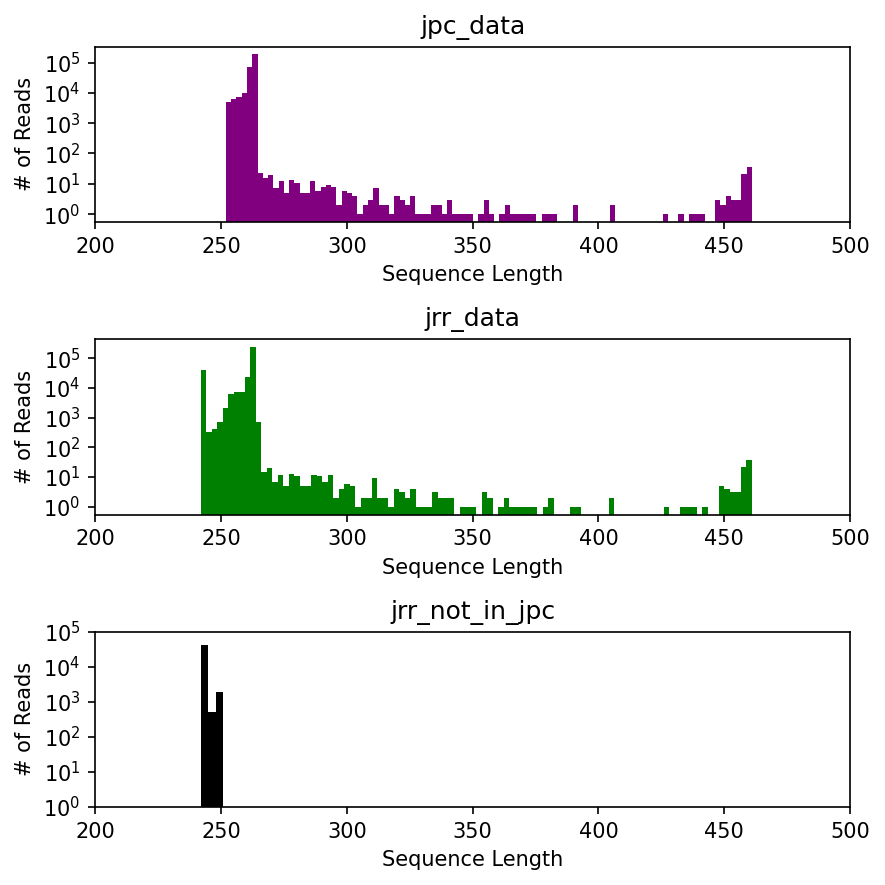

In [36]:
fig = plt.figure(figsize=(6, 6))
fig.set_dpi(150)

kwargs ={
        'alpha': 1
}

dfs = {'jpc_data': jpcdf,
       'jrr_data': jrrdf,
       'jrr_not_in_jpc': only_jrr}

yvar = 'length'

ticks = np.arange(0, 6, 1)
logticks = np.power(10, ticks)
colors = ['purple', 'green', 'black']
bin_ns = [100, 100, 3]
i = 1
for key, df in dfs.items():
    ax = fig.add_subplot(3, 1, i)
    y = df[yvar]
    rng = np.max(y) - np.min(y)
    n_bins = int(np.round(rng/10))
    n_bins = bin_ns[i-1]
    ax.hist(y, color=colors[i-1], bins=n_bins, **kwargs)
    ax.set_title(key)
    
    ax.set_yscale('log')
    ax.set_xlabel('Sequence Length')
    ax.set_ylabel('# of Reads')
    ax.set_xlim(200, 500)
    ax.set_xticks([200, 250, 300, 350, 400, 450, 500])
    ax.set_yticks(logticks)
    
    i +=1
    
# plt.show()
plt.tight_layout()

# Number of unique mutants between workflow steps

In [1]:
import re
import os

import pysam
import gzip

import pandas as pd
import numpy as np

import skbio
import dna
import Bio
from Bio import SeqIO

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from spikedisplay import plotting, io
from importlib import reload
for mod in [plotting, io]:
    reload(mod)
# plotting.set_styles(plt, matplotlib)

AMINO_ACID_ORDER = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', "*"]

In [2]:
output_dir = '/root/projects/dms/output'
# spikedisplay.io.create_all_bam_df() matches barcode in the bam
# sequence id to true barcodes in constants.rbd_barcode_index 
# using a fuzzy lookup with cdifflib and assigns bin number.
# If no good barcode match found, then bin is assigned 0
alldf, dfs = io.create_all_bam_df(output_dir)

FLAG-Lib2_S4_L001_001_bam.csv.gz


/root/venvs/.dms/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


FLAG-Lib1_S3_L001_001_bam.csv.gz
Integrated-Lib2_S6_L001_001_bam.csv.gz
ACE2-Lib1_S1_L001_001_bam.csv.gz
Plasmid-Lib2_S8_L001_001_bam.csv.gz
Plasmid-Lib1_S7_L001_001_bam.csv.gz
Integrated-Lib1_S5_L001_001_bam.csv.gz
ACE2-Lib2_S2_L001_001_bam.csv.gz


In [200]:
# filter alldf down to only mutants with a certain number of reads
thresh = 0
cols = ['mutant_aa', 'mismatch_index_in_full_length_wt_seq', 'sample_name']

groupdf = alldf.groupby(cols).count()
indices = groupdf.loc[groupdf.seq_id>=thresh, :].index

alldf_100 = alldf.set_index(cols).loc[indices, :]

filtered_df = alldf_100.copy()
cols = ['mutant_aa', 'mismatch_index_in_full_length_wt_seq']

counts = []
names = []
libraries = []
i=0
fns = list(filtered_df.source_file.unique())
dfs = []
for filename in fns:
    newdf = filtered_df[filtered_df.source_file==filename]
    newdf.reset_index(inplace=True)
    dfs.append(newdf)
for df in dfs:
    
    print(f'Analyzing bamdf {i+1} of {len(dfs)}')
    df.set_index(cols, inplace=True)
    sample_name = df.sample_name.iloc[0]
    library = df.library_name.iloc[0]
    n_unique_mutants = len(df.index.unique())
    counts.append(n_unique_mutants)
    names.append(sample_name)
    libraries.append(library)
    
    i+=1
    
    df.reset_index(inplace=True)
    
count_dict = {'sample_name': names,
              'n_unique_mutants': counts,
              'library': libraries}
count_df = pd.DataFrame(count_dict)

Analyzing bamdf 1 of 8
Analyzing bamdf 2 of 8
Analyzing bamdf 3 of 8
Analyzing bamdf 4 of 8
Analyzing bamdf 5 of 8
Analyzing bamdf 6 of 8
Analyzing bamdf 7 of 8
Analyzing bamdf 8 of 8


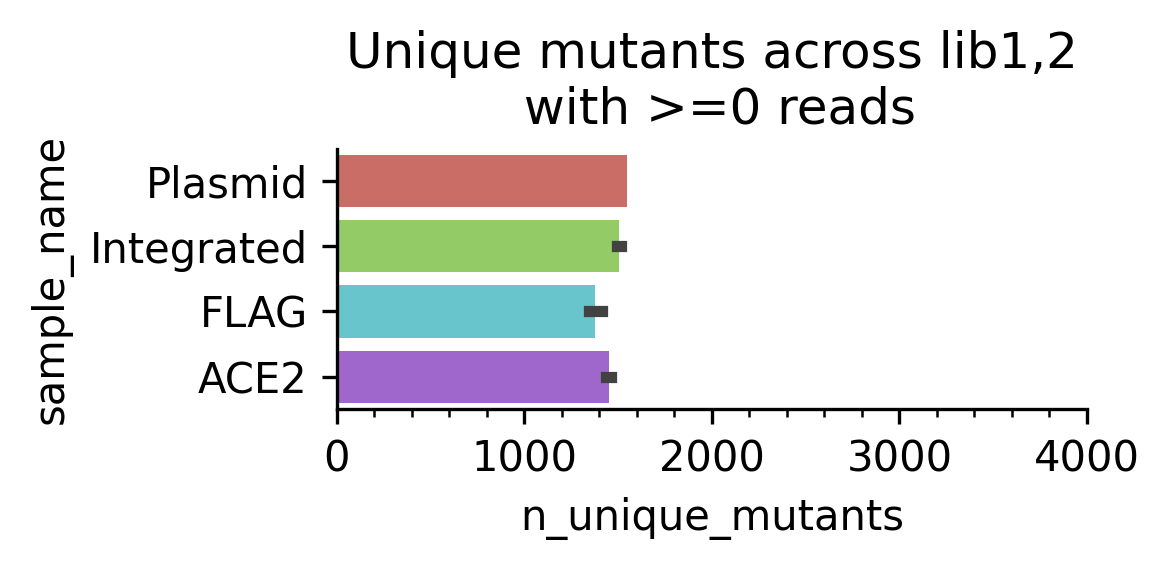

In [201]:
x_order = [
    'Plasmid',
    'Integrated',
    'FLAG',
    'ACE2',
]

hue_order = ['Lib1',
             'Lib2']

fig = plt.figure(figsize=(4, 2))
fig.set_dpi(300)
ax = fig.add_subplot(111)

kwargs = {
    'y': 'sample_name',
    'x': 'n_unique_mutants',
    'order': x_order,
    'data': count_df,
    'orient': 'horizontal',
    'palette': 'hls'
}

sns.barplot(**kwargs)

for spine in [ax.spines[key] for key in ['top', 'right']]:
    spine.set_visible(False)

ax.set_xlim(0, 4000)
ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.set_title(f'Unique mutants across lib1,2\n with >={thresh} reads')
plt.tight_layout()
fig.savefig(f'coverage_summary_with_over_{thresh}_reads.jpg')

## Histogram of number of sequences with x number of reads per sample

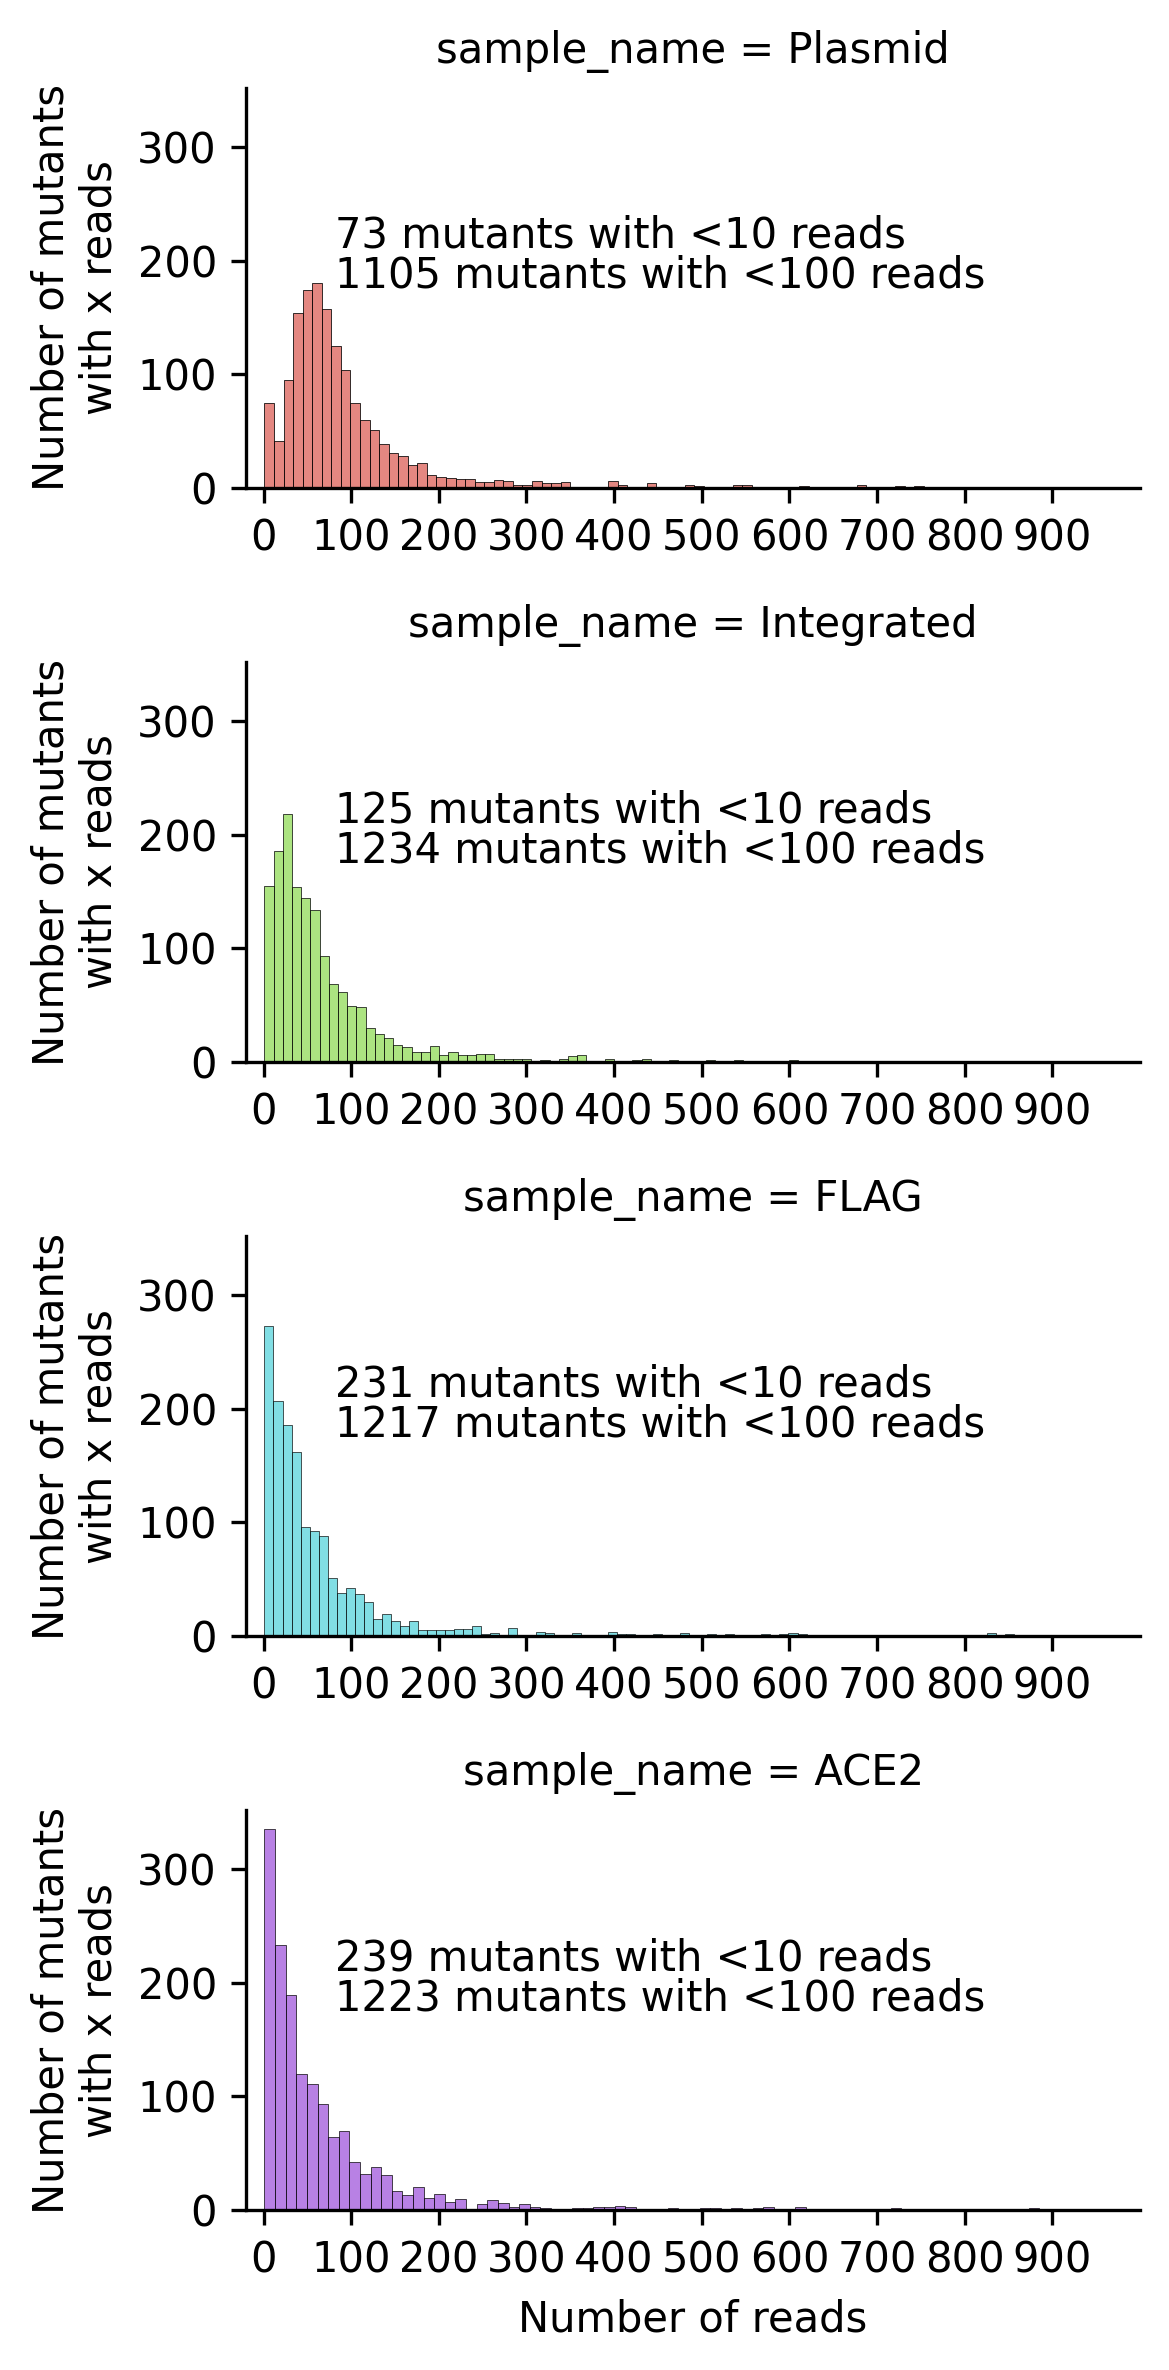

In [5]:
cols = ['mutant_aa', 'mismatch_index_in_full_length_wt_seq', 'sample_name']
groupdf = alldf.groupby(cols).count().reset_index()
# Get rid of wild-type since it dominates the histogram
filt_groupdf = groupdf[groupdf.mismatch_index_in_full_length_wt_seq!=-1]
def annotate(data, **kwargs):
    threshold = kwargs.get('threshold', 10)
    xpos = kwargs.get('xpos', 0.1)
    ypos = kwargs.get('ypos', 0.6)
    n = len(data[data.seq_id<threshold])
    ax = plt.gca()
    ax.text(xpos, ypos, f'{n} mutants with <{threshold} reads', transform=ax.transAxes)

hue_order = ['Plasmid', 'Integrated', 'FLAG', 'ACE2']

gridkwargs = {
    'data': filt_groupdf,
    'row': 'sample_name',
    'hue': 'sample_name',
    'palette': 'hls',
    'hue_order': hue_order,
    'row_order': hue_order,
    'sharex': False
}
histkwargs = {
    'x': 'seq_id'
}
g = sns.FacetGrid(**gridkwargs)
g.map_dataframe(sns.histplot, **histkwargs)
g.map_dataframe(annotate, threshold=10)
g.map_dataframe(annotate, threshold=100, ypos=0.5)

g.set_axis_labels('Number of reads', 'Number of mutants\nwith x reads')
g.figure.set_figheight(8)
g.figure.set_figwidth(4)
g.figure.set_dpi(300)
g.set(xticks=np.arange(0, 1000, 100))
g.set(xlim=(-20, 1000))
plt.tight_layout()
g.figure.savefig('RBD_counts_per_mutant_hists_over_samples.jpg')

In [5]:
# If only middle third amplified, what is maximal coverage?
total_aa = 201
section = 201/3
total = section * 20
total

1340.0

## Correlation of coverage between steps in library generation, integration, and sorting

In [6]:
cols = ['variant_name',
        'sample_library',
        'library_name',
        'sample_name']
groupdf = alldf.groupby(cols).count().reset_index()
# Get rid of wild-type since it dominates the histogram
filt_groupdf = groupdf[groupdf.mismatch_index_in_full_length_wt_seq!=-1]

In [7]:
plasmid1df = filt_groupdf[filt_groupdf.sample_library=='Plasmid-Lib1'].reset_index()
plasmid2df = filt_groupdf[filt_groupdf.sample_library=='Plasmid-Lib2'].reset_index()

lib1df = filt_groupdf[filt_groupdf.library_name=='Lib1'].reset_index()
lib2df = filt_groupdf[filt_groupdf.library_name=='Lib2'].reset_index()

/root/projects/spikedisplay/spikedisplay/plotting.py:148: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xlim)
/root/projects/spikedisplay/spikedisplay/plotting.py:149: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(ylim)


Saved figure at /root/projects/spikedisplay/notebooks/Plasmid-Lib2_variant_coverage_correlations.png


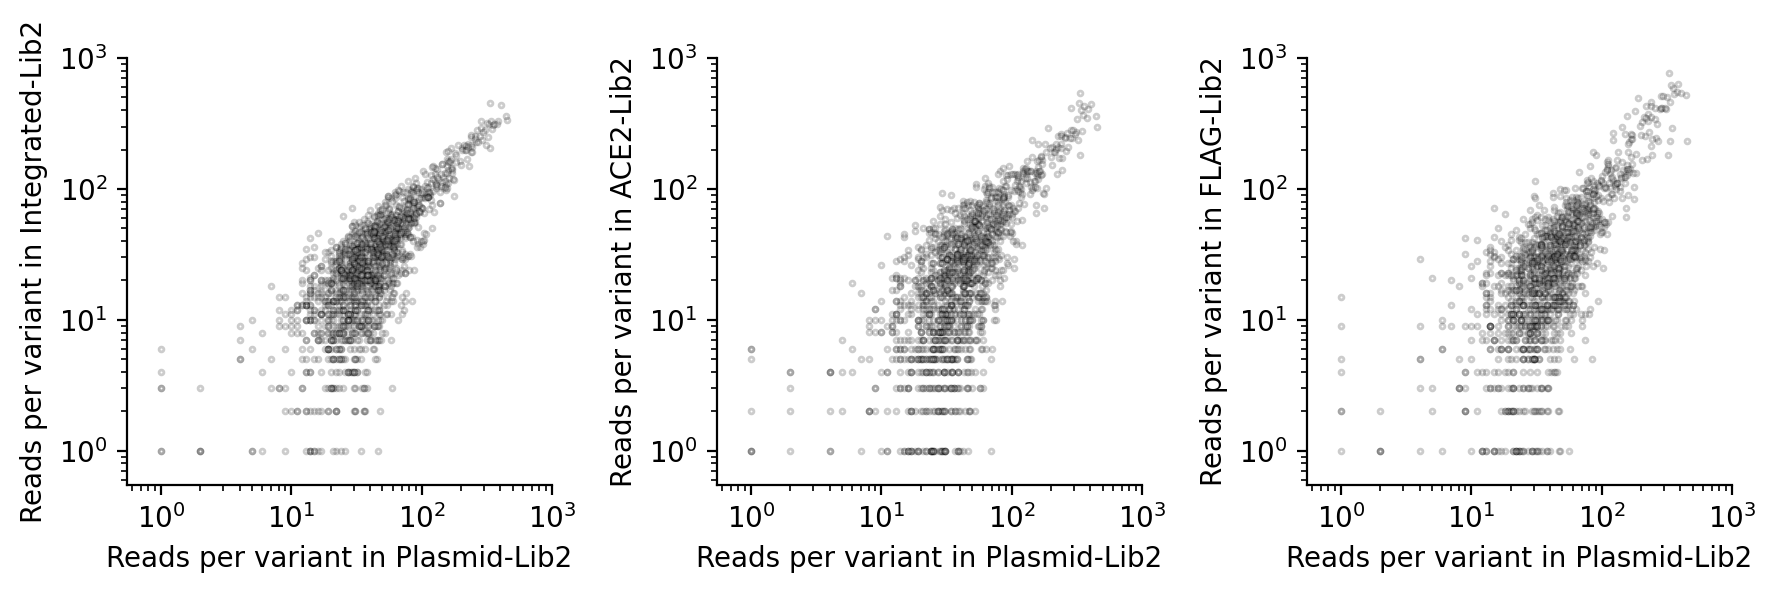

In [8]:
plotting.plot_library_correlations(plasmid2df, lib2df)

Saved figure at /root/projects/spikedisplay/notebooks/Plasmid-Lib1_variant_coverage_correlations.png


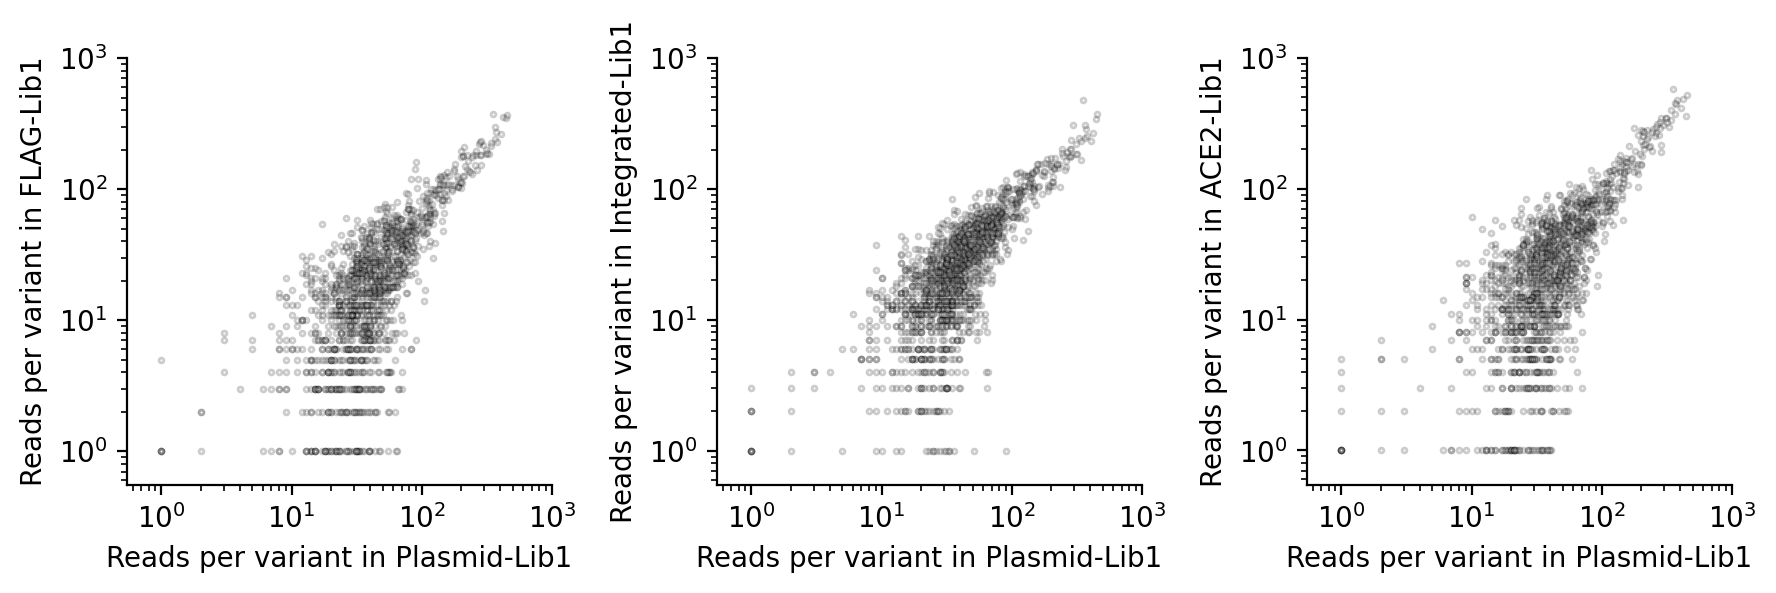

In [9]:
plotting.plot_library_correlations(plasmid1df, lib1df)

# Summarize read loss over various processing steps

In [10]:
import re
import os

import pysam
import gzip

import pandas as pd
import numpy as np

import skbio
import dna
import Bio
from Bio import SeqIO

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from spikedisplay import plotting, io, constants
from importlib import reload
for mod in [plotting, io, constants]:
    reload(mod)
plotting.set_styles(plt, matplotlib)

font.sans-serif Arial
mathtext.default regular


In [12]:
# Read in barcoded alignment files so we can count those
output_dir = '/root/projects/dms/output'
alldf, dfs = io.create_all_bam_df(output_dir)
bcdf = constants.rbd_barcode_index

FLAG-Lib2_S4_L001_001_bam.csv.gz
FLAG-Lib1_S3_L001_001_bam.csv.gz
Integrated-Lib2_S6_L001_001_bam.csv.gz
ACE2-Lib1_S1_L001_001_bam.csv.gz
Plasmid-Lib2_S8_L001_001_bam.csv.gz
Plasmid-Lib1_S7_L001_001_bam.csv.gz
Integrated-Lib1_S5_L001_001_bam.csv.gz
ACE2-Lib2_S2_L001_001_bam.csv.gz


In [13]:
outputdir = '/root/projects/dms/output/'
filename = 'qc-counts.csv'
filepath = os.path.join(outputdir, filename)

qccountsdf = pd.read_csv(filepath, header=None)
qccountsdf.columns = ['sample_name', 'reads_type', 'n_reads']
qccountsdf.head()

sample_name     reads_type  n_reads
0        FLAG-Lib1_S3_L001_001  Forward_reads   659759
1  Integrated-Lib2_S6_L001_001  Forward_reads   831534
2  Integrated-Lib1_S5_L001_001  Forward_reads   852805
3     Plasmid-Lib1_S7_L001_001  Forward_reads   795422
4        ACE2-Lib2_S2_L001_001  Forward_reads   883818

In [14]:
# Add barcoded read numbers and numbers not wild type
source_files = alldf.source_file.unique()
sample_names = [f.replace('_bam.csv.gz', '') for f in source_files]
barcoded_reads = [len(df[df.bin_number!=0]) for df in dfs]
barcoded_dfs = [df[df.bin_number!=0] for df in dfs]
nonwt_reads = [len(df[~df.is_wt]) for df in barcoded_dfs]
wt_reads = [len(df[df.is_wt]) for df in barcoded_dfs]
barcoded_reads_dict = dict(zip(sample_names, barcoded_reads))

reads_type = 'barcode_called_reads'
dicts = [dict(zip(sample_names, reads)) for reads in [barcoded_reads, nonwt_reads, wt_reads]]
reads_types = ['barcoded_reads', 'non-wt_reads', 'wt_reads']
for i, reads_type in enumerate(reads_types):
    reads_dict = dicts[i]
    for key, val in reads_dict.items():
        print(key, val)
        rowdict = {
            'sample_name': key,
            'reads_type': reads_type,
            'n_reads': val
        }
        index = qccountsdf.index.max() + 1
        qccountsdf = qccountsdf.append(pd.DataFrame(rowdict, index=[index]),
                                       ignore_index=False)

sample_labels = qccountsdf.sample_name.str[0:-12]
qccountsdf.loc[: , 'sample_label'] = sample_labels

FLAG-Lib2_S4_L001_001 209351
FLAG-Lib1_S3_L001_001 162052
Integrated-Lib2_S6_L001_001 198886
ACE2-Lib1_S1_L001_001 228613
Plasmid-Lib2_S8_L001_001 237664
Plasmid-Lib1_S7_L001_001 257897
Integrated-Lib1_S5_L001_001 205613
ACE2-Lib2_S2_L001_001 208081
FLAG-Lib2_S4_L001_001 63761
FLAG-Lib1_S3_L001_001 40709
Integrated-Lib2_S6_L001_001 57990
ACE2-Lib1_S1_L001_001 58650
Plasmid-Lib2_S8_L001_001 76630
Plasmid-Lib1_S7_L001_001 75992
Integrated-Lib1_S5_L001_001 53106
ACE2-Lib2_S2_L001_001 54841
FLAG-Lib2_S4_L001_001 145590
FLAG-Lib1_S3_L001_001 121343
Integrated-Lib2_S6_L001_001 140896
ACE2-Lib1_S1_L001_001 169963
Plasmid-Lib2_S8_L001_001 161034
Plasmid-Lib1_S7_L001_001 181905
Integrated-Lib1_S5_L001_001 152507
ACE2-Lib2_S2_L001_001 153240


In [15]:
reload(plotting)

<module 'spikedisplay.plotting' from '/root/projects/spikedisplay/spikedisplay/plotting.py'>

[Text(0, 0, 'Plasmid-Lib1'),
 Text(0, 0, 'Plasmid-Lib2'),
 Text(0, 0, 'Integrated-Lib1'),
 Text(0, 0, 'Integrated-Lib2'),
 Text(0, 0, 'FLAG-Lib1'),
 Text(0, 0, 'FLAG-Lib2'),
 Text(0, 0, 'ACE2-Lib1'),
 Text(0, 0, 'ACE2-Lib2')]

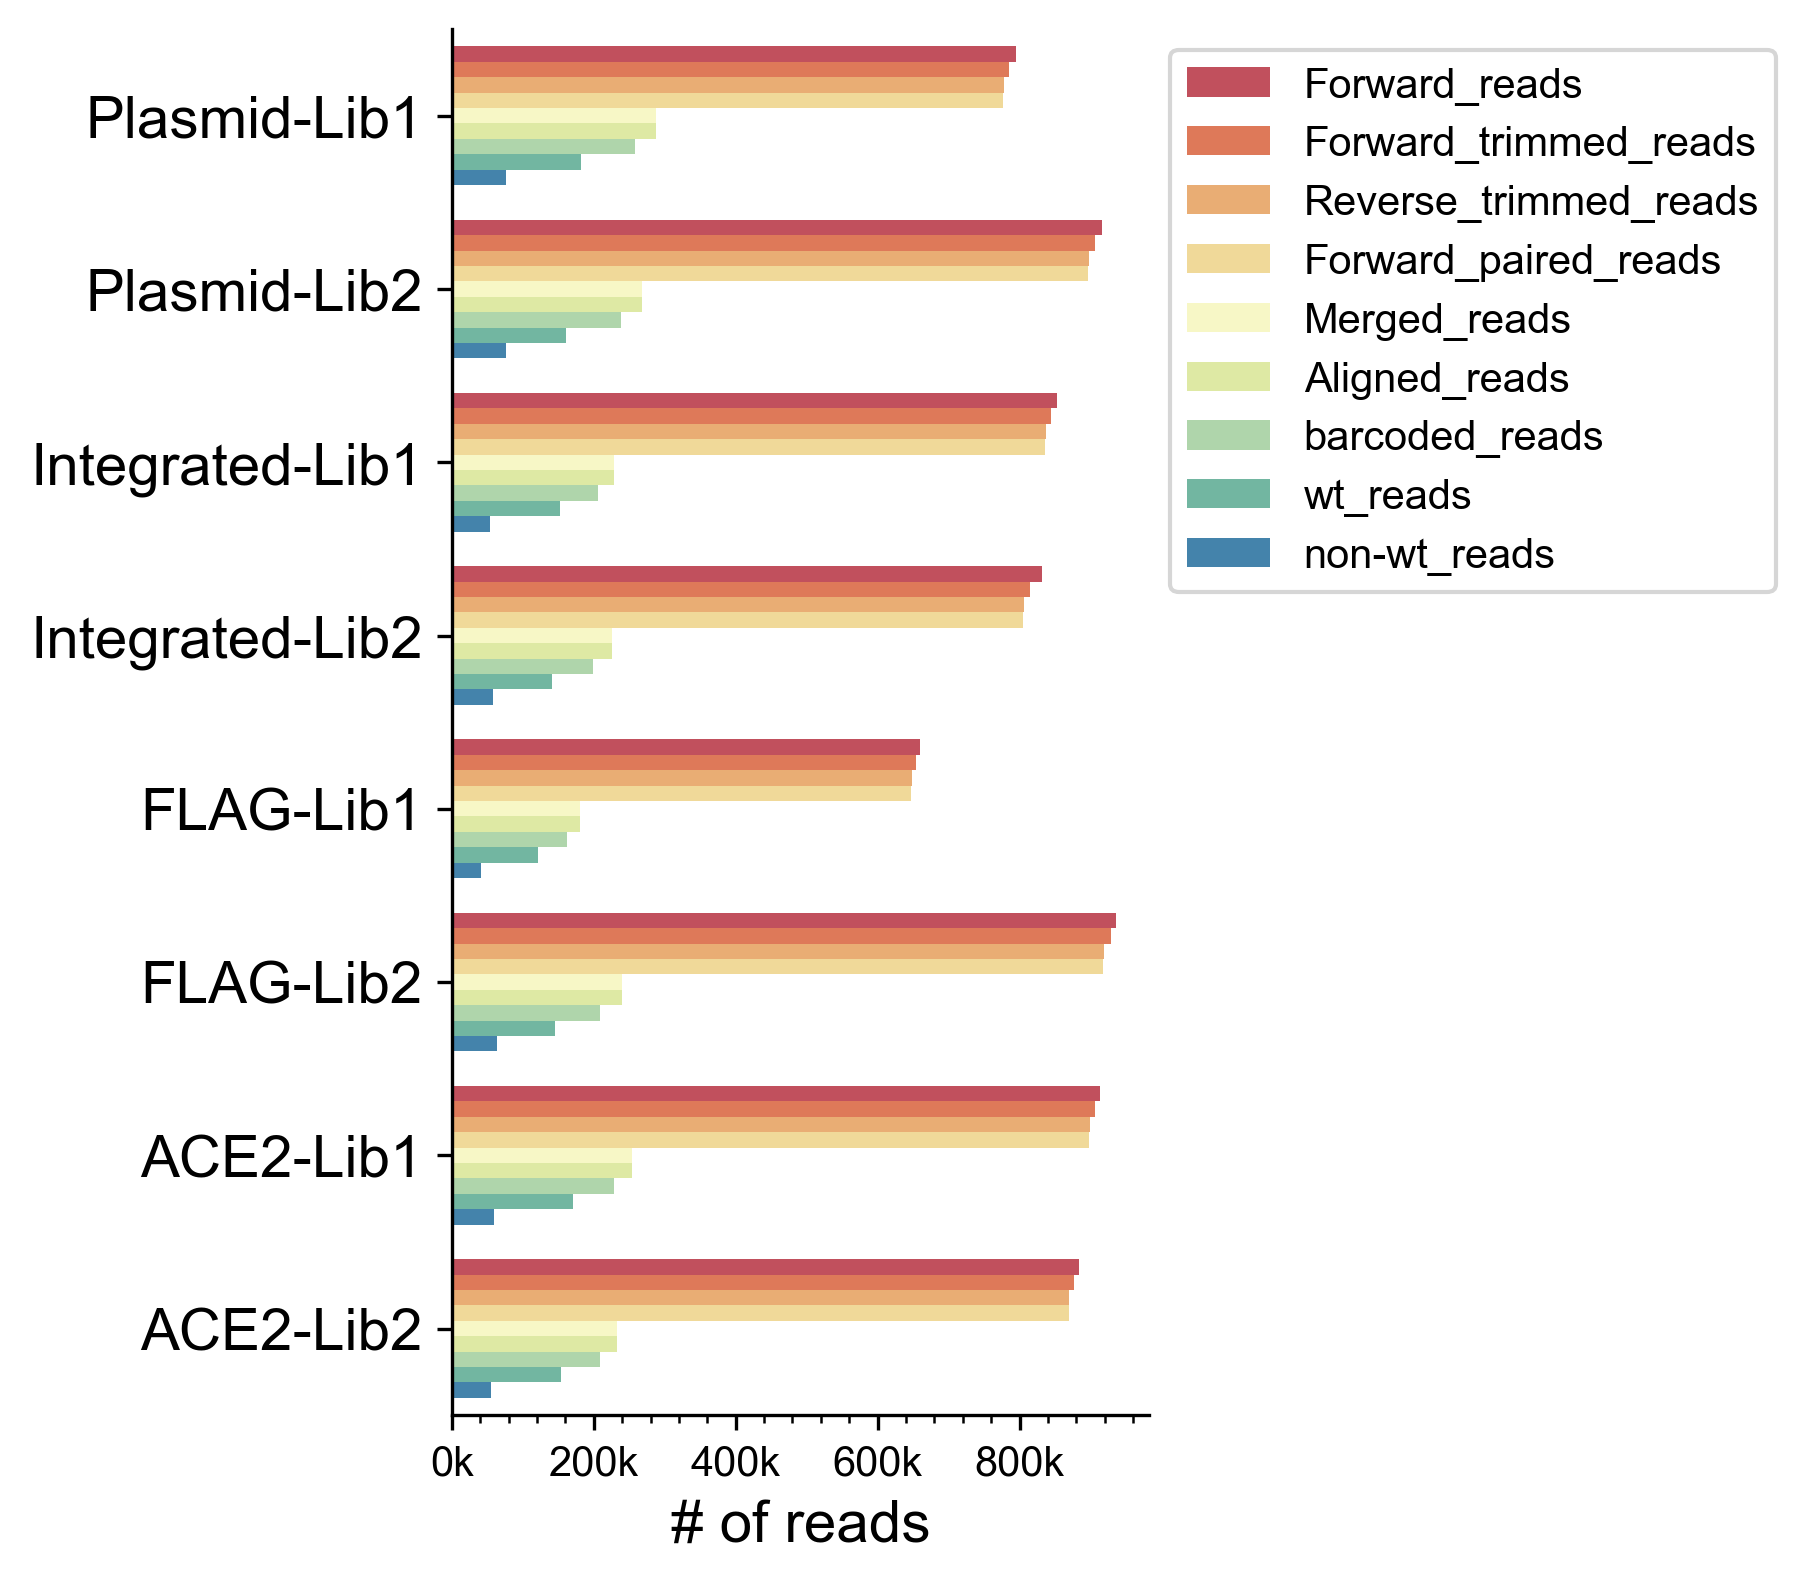

In [16]:
sample_order = [
    'Plasmid-Lib1',
    'Plasmid-Lib2',
    'Integrated-Lib1',
    'Integrated-Lib2',
    'FLAG-Lib1',
    'FLAG-Lib2',
    'ACE2-Lib1',
    'ACE2-Lib2'
]

wanted_read_types = [
    'Forward_reads',
    'Forward_trimmed_reads',
    'Reverse_trimmed_reads',
    'Forward_paired_reads',
    'Merged_reads',
    'Aligned_reads',
    'barcoded_reads',
    'wt_reads',
    'non-wt_reads'
]



fig = plt.figure(figsize=(3, 6))
fig.set_dpi(300)
ax = fig.add_subplot(111)
df = qccountsdf[qccountsdf.reads_type.isin(wanted_read_types)]

barkwargs = {
    'y': 'sample_label',
    'x': 'n_reads',
    'hue': 'reads_type',
    'order': sample_order,
    'hue_order': wanted_read_types,
    'orientation': 'horizontal',
    'ax': ax,
    'data': df,
    'palette': 'Spectral'
}
fontsize = 14
sns.barplot(**barkwargs)

for spine in [ax.spines[name] for name in ['top', 'right']]:
    spine.set_visible(False)
ax.legend(bbox_to_anchor=(1, 1))

plotting.human_format(ax, axname='x')
plotting.format_ticks(ax, format_y_ticks=False, tickdirection='out')

ax.set_ylabel('')
ax.set_xlabel('# of reads', fontsize=fontsize)
axlabels = ax.get_yticklabels()
ax.set_yticklabels(axlabels, fontsize=fontsize)

### Stacked bar

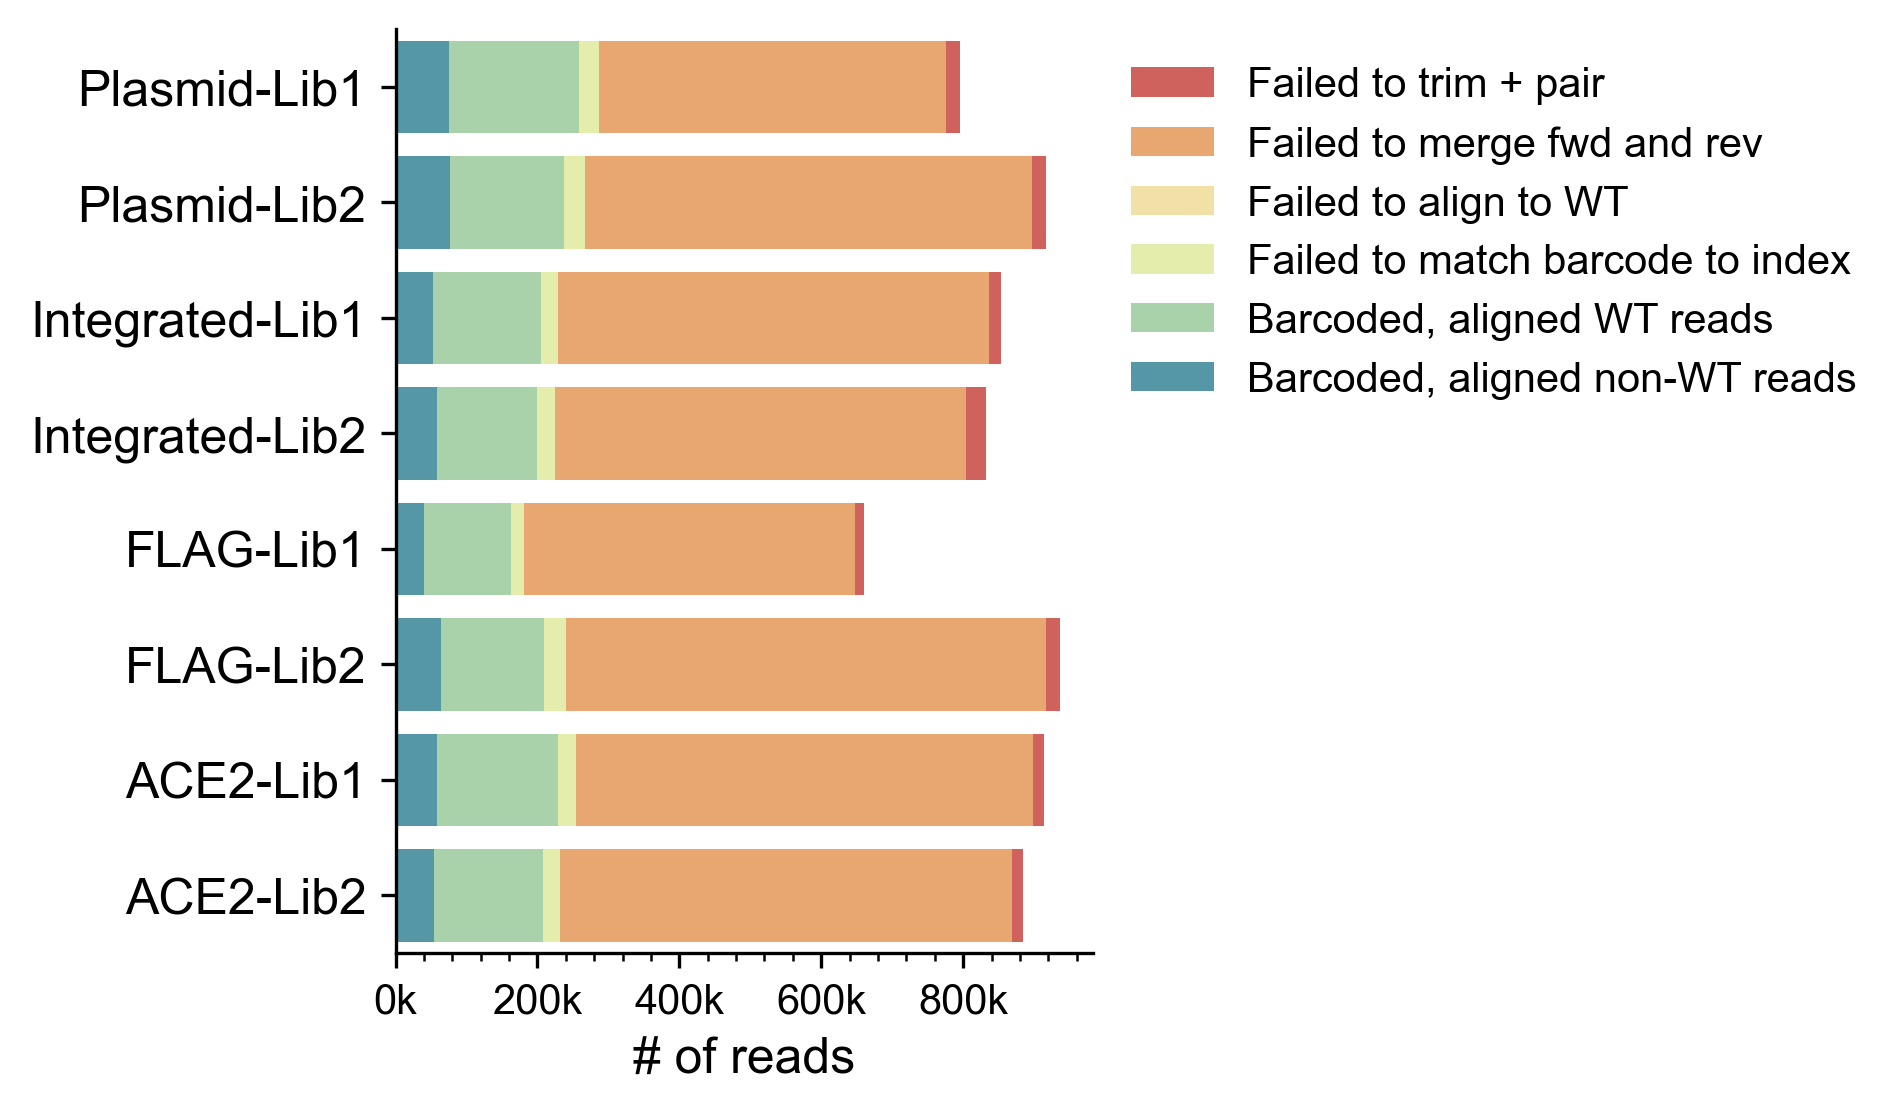

In [17]:
sample_order = [
    'Plasmid-Lib1',
    'Plasmid-Lib2',
    'Integrated-Lib1',
    'Integrated-Lib2',
    'FLAG-Lib1',
    'FLAG-Lib2',
    'ACE2-Lib1',
    'ACE2-Lib2'
]

wanted_read_types = [
    'Forward_reads',
    'Forward_paired_reads',
    'Merged_reads',
    'Aligned_reads',
    'barcoded_reads',
    'non-wt_reads'
]

read_type_labels = [
    'Failed to trim + pair',
    'Failed to merge fwd and rev',
    'Failed to align to WT',
    'Failed to match barcode to index',
    'Barcoded, aligned WT reads',
    'Barcoded, aligned non-WT reads'
]

# wanted_read_types.reverse()

fig = plt.figure(figsize=(3, 4))
fig.set_dpi(300)
ax = fig.add_subplot(111)
df = qccountsdf[qccountsdf.reads_type.isin(wanted_read_types)]

barkwargs = {
    'y': 'sample_label',
    'x': 'n_reads',
    'hue': 'reads_type',
    'order': sample_order,
    'hue_order': wanted_read_types,
    'orientation': 'horizontal',
    'ax': ax,
    'data': df,
    'palette': 'Spectral',
    'dodge': False
}
fontsize = 12
sns.barplot(**barkwargs)


# Formatting stuff
for spine in [ax.spines[name] for name in ['top', 'right']]:
    spine.set_visible(False)

plotting.format_ticks(ax, format_y_ticks=False, tickdirection='out')
plotting.human_format(ax, axname='x')

ax.set_ylabel('')
ax.set_xlabel('# of reads', fontsize=fontsize)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=fontsize)
h, l = ax.get_legend_handles_labels()
ax.legend(h, read_type_labels, bbox_to_anchor=(1, 1), frameon=False)

# Assigning functional score to variants

In [59]:
import re
import os

import pysam
import gzip

import pandas as pd
import numpy as np

import skbio
import dna
import Bio
from Bio import SeqIO

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from spikedisplay import plotting, io, constants, fitting, normalization
from importlib import reload
for mod in [plotting, io, constants, fitting, normalization]:
    reload(mod)
plotting.set_styles(plt, matplotlib)

# Read in barcoded alignment files so we can count those

output_dir = '/root/projects/dms/output'
alldf, dfs = io.create_all_bam_df(output_dir)
bcdf = constants.rbd_barcode_index

font.sans-serif Arial
mathtext.default regular
FLAG-Lib2_S4_L001_001_bam.csv.gz


/root/venvs/.dms/lib/python3.6/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


FLAG-Lib1_S3_L001_001_bam.csv.gz
Integrated-Lib2_S6_L001_001_bam.csv.gz
ACE2-Lib1_S1_L001_001_bam.csv.gz
Plasmid-Lib2_S8_L001_001_bam.csv.gz
Plasmid-Lib1_S7_L001_001_bam.csv.gz
Integrated-Lib1_S5_L001_001_bam.csv.gz
ACE2-Lib2_S2_L001_001_bam.csv.gz


In [211]:
22911930/6600000

3.4715045454545455

In [229]:
new_reads = 600000

read_fractions = readsperbin.seq_id/(np.sum(readsperbin.seq_id))

added_reads = read_fractions*new_reads

In [231]:
added_reads/cell_counts

bin_number
1    0.042711
2    0.202294
3    0.287968
4    0.119940
Name: seq_id, dtype: float64

In [232]:
6600000/99648

66.23314065510597

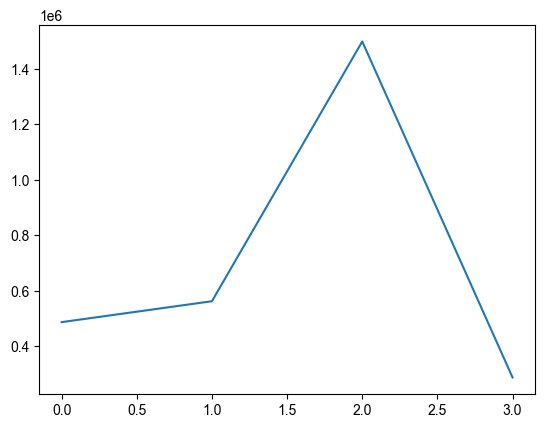

In [528]:
plt.plot(cell_counts)

In [547]:
wanted_samples = ['ACE2-Lib1',
                  'FLAG-Lib1']

reads_threshold = 200

dfs = [df for df in dfs if df.sample_library.iloc[0] in wanted_samples]
# Get rid of reads with unassigned bin from barcode
dfs = [df[df.bin_number!=0] for df in dfs]
# Choose the ACE2-Lib1 sample
df = dfs[1]
# This is manually entered. It's the number of cell counts
# per bin from Ankur. Order is bin 1-4
cell_counts = [
    486299,
    561610,
    1497420,
    286894
]
readsperbin.loc[:, 'number_of_cells'] = cell_counts
# Optionally get rid of wild-type sequences
# df = df[df.is_wt==False]

count_gb_index = [
        'is_wt',
        'mutant_aa',
        'wt_aa_at_mismatch',
        'mismatch_index_in_full_length_wt_seq',
        'source_file',
        'sample_name',
        'library_name',
        'variant_name',
        'sample_library',
        'bin_number'
    ]

dfcount = df.groupby(count_gb_index).count().reset_index()
# Only keep variants with over a certain number of reads each
# before calculating normalized bins
keep_variants = []
dfcount.set_index(['variant_name'], inplace=True)
for variant in list(dfcount.index.unique()):
    if np.sum(dfcount.loc[variant, 'seq_id']) > reads_threshold:
        keep_variants.append(variant)

dfcount = dfcount.loc[keep_variants, :]

df = df[df.variant_name.isin(keep_variants)]
readsperbin = df.groupby(['bin_number']).count()
readsperbin.loc[:, 'number_of_cells'] = cell_counts
readsperbin.loc[:, 'nreads_to_ncells'] = readsperbin.seq_id/readsperbin.number_of_cells

total_reads_in_sample = readsperbin['seq_id'].sum()
total_cells_in_sample = readsperbin['number_of_cells'].sum()
for bin_number in [1, 2, 3, 4]:
    
    total_reads_in_bin = readsperbin.loc[bin_number, 'seq_id']
    total_cells_in_bin = readsperbin.loc[bin_number, 'number_of_cells']
    bin_fraction_reads = total_reads_in_bin/total_reads_in_sample
    bin_fraction_cells = total_cells_in_bin/total_cells_in_sample
    # Can either use bin_fraction cells or bin_fraction_reads to 
    # normalize variant read counts per bin to fraction of all reads
    # found in that bin.
    # Based on Starr et al. 2020 Cell,if read counts per bin are lower
    # than cell counts per bin, potentially cell counts should be used to weight
    # bins. Otherwise, the ratio of read:cell count per bin should be
    # used
    weight = 1/bin_fraction_reads
    print(f'{total_reads_in_bin} reads for bin {bin_number} ({bin_fraction_reads}, {weight})')
    boolean = dfcount.bin_number==bin_number
    dfcount.loc[boolean, normcolname] = dfcount.loc[boolean, 'seq_id']/total_reads_in_bin
    dfcount.loc[boolean, 'bin_fraction'] = bin_fraction
    dfcount.loc[boolean, 'bin_weight'] = weight
    
dfcount.loc[:, 'unweighted_variant_reads_in_bin'] = dfcount.seq_id
dfcount.loc[:, 'weighted_variant_reads_in_bin'] = dfcount.bin_weight*dfcount.unweighted_variant_reads_in_bin

dfcount.reset_index(inplace=True)

6093 reads for bin 1 (0.03324693749488446, 30.077958312817987)
33109 reads for bin 2 (0.18066188306550623, 5.535201908846537)
133572 reads for bin 3 (0.7288462063132622, 1.3720315635013325)
10491 reads for bin 4 (0.05724497312634709, 17.468782766180535)


(0.0, 500.0)

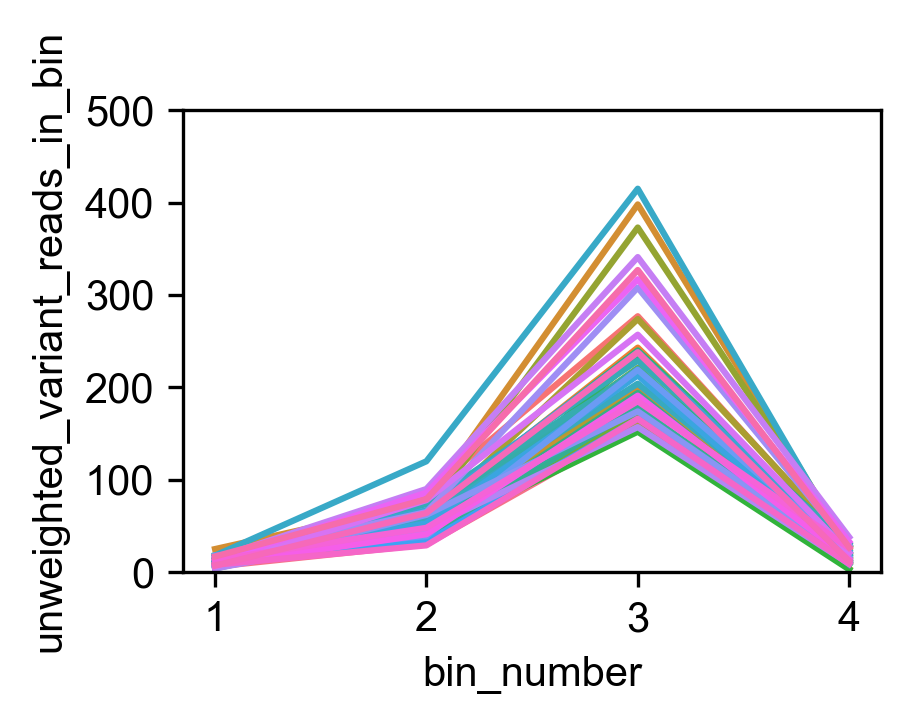

In [548]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
fig.set_dpi(300)
violinkwargs = {
    'x': 'bin_number',
    'y':'unweighted_variant_reads_in_bin',
    'hue': 'variant_name',
    'data': dfcount,
    'legend': False,
    'ax': ax
}

sns.lineplot(**violinkwargs)
ax.set_ylim(0, 500)

(0.0, 700.0)

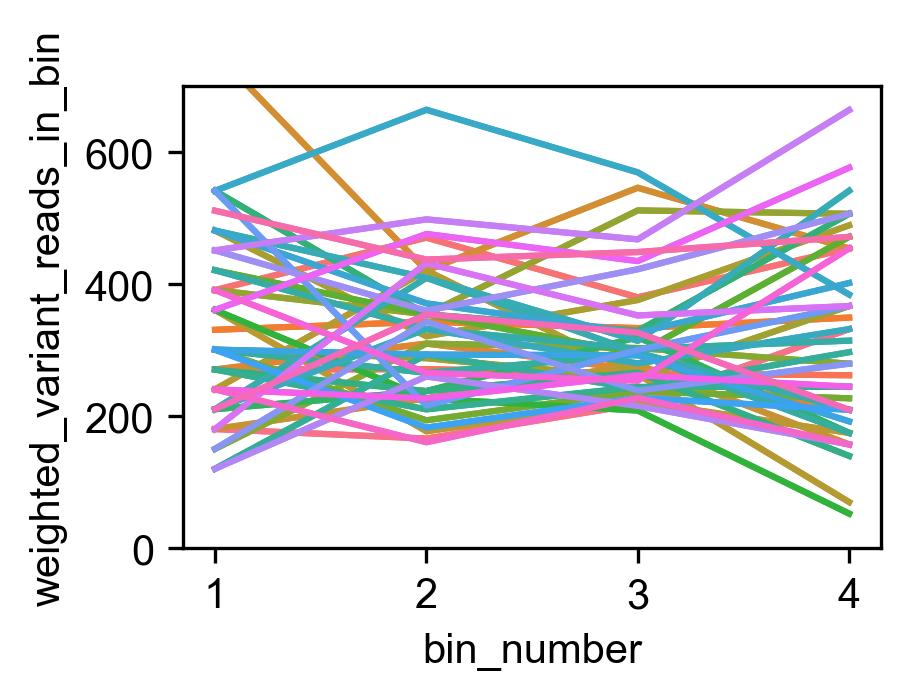

In [549]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
fig.set_dpi(300)

violinkwargs = {
    'x': 'bin_number',
    'y':'weighted_variant_reads_in_bin',
    'hue': 'variant_name',
    'data': dfcount,
    'legend': False
}

sns.lineplot(**violinkwargs)

sns.lineplot(**violinkwargs)
ax.set_ylim(0, 700)

In [536]:
weighted_mean

2.50320035584173

In [537]:
x

array([1, 2, 3, 4])

In [538]:
y

array([169831.45394737, 168599.29511847, 170249.74538398, 170730.87595768])

In [540]:
weights*x

array([0.24996852, 0.4963099 , 0.75175256, 1.00516938])

In [539]:
weights

array([0.24996852, 0.24815495, 0.25058419, 0.25129234])

In [550]:
# Weighting bin number by number of reads in that bin
xvar = 'bin_number'
yvar = 'weighted_variant_reads_in_bin'

dfc = dfcount.set_index('variant_name')
dfc.loc[:, 'weighted_mean_bin'] = np.nan
dfc.loc[:, 'total_variant_reads'] = np.nan
dfc.loc[:, 'gaussian_center_norm_bin_reads'] = np.nan
dfc.loc[:, 'mode_bin'] = np.nan
constraints = (0, [1000, 6., 6.])

xs = []
ys = []
total_reads = []
for variant in dfc.index.unique():
    print(variant)
    x = np.array(dfc.loc[variant, xvar])
    y = np.array(dfc.loc[variant, yvar])
    x, y = fitting.fill_in_bins(x, y, unique_bins=[1, 2, 3, 4])
    mode_bin = x[np.argmax(y)]
#     popt, pcov = fitting.curve_fit(fitting.gaussian, x, y, bounds=constraints)
#     center = popt[1]
    dfc.loc[variant, 'gaussian_center_norm_bin_reads'] = center
    dfc.loc[variant, 'mode_bin'] = mode_bin
    xs.append(x)
    ys.append(y)
    weights = y/np.sum(y)
    weighted_mean = np.sum(weights*x)
    dfc.loc[variant, 'weighted_mean_bin'] = weighted_mean
    # seq_id is sum of filled values in the seq_id column
    # of the bam_df (one row per unique read)
    total_variant_reads = dfc.loc[variant, 'seq_id'].sum()
    dfc.loc[variant, 'total_variant_reads'] = total_variant_reads
    total_reads.append(total_variant_reads)
if 'bin_number' in count_gb_index:
    count_gb_index.remove('bin_number')

fits_df = dfc.pivot_table(index=count_gb_index, aggfunc=np.median).reset_index()

G83C
G86C
G117C
W106C
E76D
E135D
E141D
V65E
D97H
P133H
Q79H
Q84H
R136I
Q84K
Q144K
F70L
F134L
R78L
R124L
W106L
L111M
L122M
L131M
D97N
K87N
K114N
A145P
P82Q
R127S
T140S
P82T
D59Y
D68Y
D75Y
D90Y
D97Y
D98Y
D137Y
S69Y
S108Y
S129Y
S139Y
None0None


155


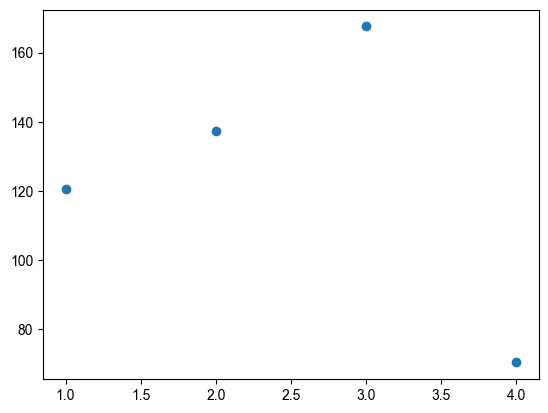

In [519]:
i = np.random.randint(0, len(xs))
print(total_reads[i])
plt.scatter(xs[i], ys[i])

In [551]:
wt_booldex = fits_df.variant_name=='None0None'
wt_mean_bin = fits_df.loc[wt_booldex, 'mode_bin'].iloc[0]

fits_df.loc[:, 'ratio_to_wt'] = fits_df.weighted_mean_bin/wt_mean_bin
fits_df.loc[:, 'log2_ratio_to_wt'] = np.log2(fits_df.ratio_to_wt)

(array([15.,  0.,  0., 12.,  0.,  0.,  5.,  0.,  0., 11.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

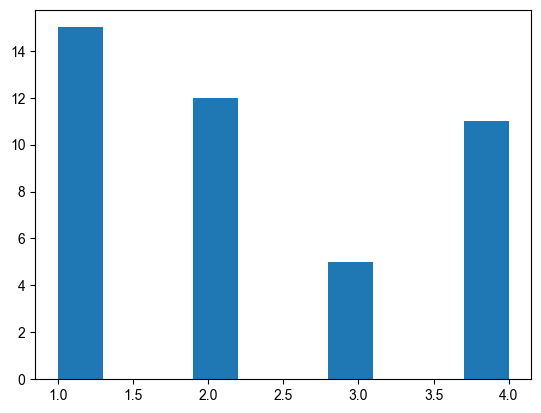

In [552]:
xvar = 'mode_bin'

# wt_booldex = fits_df.variant_name=='None0None'
# wt_mean_bin = fits_df.loc[wt_booldex, xvar].iloc[0]

ax = plt.axes()
ax.hist(fits_df[xvar])
# ax.axvline(wt_mean_bin, color='red')

In [90]:
for bamdf in dfs:

    # don't fit with any reads from unassigned bins
    bamdf = bamdf[bamdf.bin_number!=0].reset_index()
    print(f'fitting data from file {bamdf.source_file.iloc[0]}')

    fits_df = fitting.fit_bin_count_per_variant(bamdf, ycol='')

fitting data from file FLAG-Lib2_S4_L001_001_bam.csv.gz
Fitting variant 1 of 1409 with 18 reads
Fit variant with center 3.7176295288943733
Fitting variant 2 of 1409 with 33 reads
Fit variant with center 4.273682801808474
Fitting variant 3 of 1409 with 46 reads
Fit variant with center 4.851200530436621
Fitting variant 4 of 1409 with 61 reads
Fit variant with center 4.338965982796827
Fitting variant 5 of 1409 with 64 reads
Fit variant with center 4.30908341071223
Fitting variant 6 of 1409 with 9 reads
Fit variant with center 4.369066370978854
Fitting variant 7 of 1409 with 10 reads
Fit variant with center 5.011404304401801
Fitting variant 8 of 1409 with 10 reads
Fit variant with center 5.9999999999999964
Fitting variant 9 of 1409 with 64 reads


/root/venvs/.dms/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fit variant with center 4.284540283769392
Fitting variant 10 of 1409 with 9 reads
Fit variant with center 5.165392758964622
Fitting variant 11 of 1409 with 27 reads
Fit variant with center 5.478033506058115
Fitting variant 12 of 1409 with 30 reads
Fit variant with center 4.345078641262425
Fitting variant 13 of 1409 with 13 reads
Fit variant with center 3.9817420465345648
Fitting variant 14 of 1409 with 8 reads
Fit variant with center 4.59265292142085
Fitting variant 15 of 1409 with 48 reads
Fit variant with center 4.698203095318065
Fitting variant 16 of 1409 with 102 reads
Fit variant with center 4.3847466423987855
Fitting variant 17 of 1409 with 20 reads
Fit variant with center 5.999999999999995
Fitting variant 18 of 1409 with 9 reads
Fit variant with center 4.300522335649769
Fitting variant 19 of 1409 with 23 reads
Fit variant with center 4.419344101573877
Fitting variant 20 of 1409 with 50 reads
Fit variant with center 4.220987730369315
Fitting variant 21 of 1409 with 1 reads
Fit va

Fit variant with center 4.632491868953797
Fitting variant 112 of 1409 with 16 reads
Fit variant with center 4.27505166313152
Fitting variant 113 of 1409 with 5 reads
Fit variant with center 5.999999999999999
Fitting variant 114 of 1409 with 3 reads
Fit variant with center 3.91503752935507
Fitting variant 115 of 1409 with 3 reads
Fit variant with center 2.4257741684309426
Fitting variant 116 of 1409 with 52 reads
Fit variant with center 4.856559690851255
Fitting variant 117 of 1409 with 5 reads
Fit variant with center 5.999999999999539
Fitting variant 118 of 1409 with 44 reads
Fit variant with center 5.999999999999999
Fitting variant 119 of 1409 with 39 reads
Fit variant with center 4.311404482824188
Fitting variant 120 of 1409 with 23 reads
Fit variant with center 0.9096832267875169
Fitting variant 121 of 1409 with 48 reads
Fit variant with center 4.984884209045854
Fitting variant 122 of 1409 with 23 reads
Fit variant with center 5.123656344156975
Fitting variant 123 of 1409 with 18 re

Fit variant with center 2.0203985535345772e-13
Fitting variant 225 of 1409 with 11 reads
Fit variant with center 3.0165092349956226
Fitting variant 226 of 1409 with 17 reads
Fit variant with center 4.117440027276705
Fitting variant 227 of 1409 with 19 reads
Fit variant with center 4.65598633319564
Fitting variant 228 of 1409 with 10 reads
Fit variant with center 5.405882552154047
Fitting variant 229 of 1409 with 49 reads
Fit variant with center 4.364445350456437
Fitting variant 230 of 1409 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 231 of 1409 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 232 of 1409 with 31 reads
Fit variant with center 4.327682674047046
Fitting variant 233 of 1409 with 1 reads
Fit variant with center 3.9910294597597193
Fitting variant 234 of 1409 with 5 reads
Fit variant with center 2.499999998650641
Fitting variant 235 of 1409 with 13 reads
Fit variant with center 0.9166168256015654
Fitting variant 236 of 1409 w

Fit variant with center 3.9910294597597193
Fitting variant 339 of 1409 with 49 reads
Fit variant with center 4.686738912358029
Fitting variant 340 of 1409 with 68 reads
Fit variant with center 4.556299319436398
Fitting variant 341 of 1409 with 31 reads
Fit variant with center 4.783556296192188
Fitting variant 342 of 1409 with 96 reads
Fit variant with center 4.281630985430934
Fitting variant 343 of 1409 with 28 reads
Fit variant with center 4.424898640900463
Fitting variant 344 of 1409 with 135 reads
Fit variant with center 4.467811105910355
Fitting variant 345 of 1409 with 16 reads
Fit variant with center 4.768793369869642
Fitting variant 346 of 1409 with 43 reads
Fit variant with center 5.529124460807143
Fitting variant 347 of 1409 with 57 reads
Fit variant with center 4.345041216806846
Fitting variant 348 of 1409 with 25 reads
Fit variant with center 4.695058951229538
Fitting variant 349 of 1409 with 17 reads
Fit variant with center 4.009627556676229
Fitting variant 350 of 1409 with

Fit variant with center 4.5111320529298204
Fitting variant 437 of 1409 with 15 reads
Fit variant with center 2.2462330151603647
Fitting variant 438 of 1409 with 34 reads
Fit variant with center 3.936871108242983
Fitting variant 439 of 1409 with 12 reads
Fit variant with center 4.159360649703243
Fitting variant 440 of 1409 with 10 reads
Fit variant with center 5.999999999999999
Fitting variant 441 of 1409 with 27 reads
Fit variant with center 0.6673918424062817
Fitting variant 442 of 1409 with 2 reads
Fit variant with center 1.4999985970328469
Fitting variant 443 of 1409 with 10 reads
Fit variant with center 3.9910294597597193
Fitting variant 444 of 1409 with 4 reads
Fit variant with center 3.9910294597597193
Fitting variant 445 of 1409 with 135 reads
Fit variant with center 4.6662370218173015
Fitting variant 446 of 1409 with 2 reads
Fit variant with center 2.500000116929317
Fitting variant 447 of 1409 with 12 reads
Fit variant with center 4.371335920950981
Fitting variant 448 of 1409 w

Fit variant with center 5.866997307117367
Fitting variant 549 of 1409 with 78 reads
Fit variant with center 5.427422719736335
Fitting variant 550 of 1409 with 28 reads
Fit variant with center 4.642977875432303
Fitting variant 551 of 1409 with 15 reads
Fit variant with center 3.9910294597597193
Fitting variant 552 of 1409 with 8 reads
Fit variant with center 3.9910294597597193
Fitting variant 553 of 1409 with 45 reads
Fit variant with center 3.593813245248527
Fitting variant 554 of 1409 with 26 reads
Fit variant with center 3.9995456101301743
Fitting variant 555 of 1409 with 13 reads
Fit variant with center 4.797259560296575
Fitting variant 556 of 1409 with 13 reads
Fit variant with center 3.9910294597597193
Fitting variant 557 of 1409 with 11 reads
Fit variant with center 3.9910294597597193
Fitting variant 558 of 1409 with 9 reads
Fit variant with center 5.999999999999999
Fitting variant 559 of 1409 with 4 reads
Fit variant with center 5.999999999999999
Fitting variant 560 of 1409 with

Fit variant with center 4.939478670554125
Fitting variant 654 of 1409 with 39 reads
Fit variant with center 3.9974420421870396
Fitting variant 655 of 1409 with 18 reads
Fit variant with center 3.9552171576085544
Fitting variant 656 of 1409 with 27 reads
Fit variant with center 3.9910294597597193
Fitting variant 657 of 1409 with 2 reads
Fit variant with center 3.9910294597597193
Fitting variant 658 of 1409 with 11 reads
Fit variant with center 2.0146847216029004e-16
Fitting variant 659 of 1409 with 6 reads
Fit variant with center 3.9910294597597193
Fitting variant 660 of 1409 with 50 reads
Fit variant with center 4.005374055924897
Fitting variant 661 of 1409 with 62 reads
Fit variant with center 4.751631152868073
Fitting variant 662 of 1409 with 9 reads
Fit variant with center 3.9910294597597193
Fitting variant 663 of 1409 with 34 reads
Fit variant with center 5.999999999999927
Fitting variant 664 of 1409 with 18 reads
Fit variant with center 4.816021810296479
Fitting variant 665 of 140

Fit variant with center 3.9688460855039
Fitting variant 767 of 1409 with 50 reads
Fit variant with center 4.110625690659668
Fitting variant 768 of 1409 with 7 reads
Fit variant with center 3.9910294597597193
Fitting variant 769 of 1409 with 11 reads
Fit variant with center 2.8319732020944923e-15
Fitting variant 770 of 1409 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 771 of 1409 with 6 reads
Fit variant with center 5.241606027264194
Fitting variant 772 of 1409 with 35 reads
Fit variant with center 5.36993190551696
Fitting variant 773 of 1409 with 52 reads
Fit variant with center 4.30308220484778
Fitting variant 774 of 1409 with 53 reads
Fit variant with center 4.802577071672466
Fitting variant 775 of 1409 with 85 reads
Fit variant with center 4.818590554541729
Fitting variant 776 of 1409 with 233 reads
Fit variant with center 4.515369376554246
Fitting variant 777 of 1409 with 116 reads
Fit variant with center 4.301244328909205
Fitting variant 778 of 1409 with

Fit variant with center 4.221658162175244
Fitting variant 865 of 1409 with 166 reads
Fit variant with center 4.3715961112010175
Fitting variant 866 of 1409 with 52 reads
Fit variant with center 4.225494434215019
Fitting variant 867 of 1409 with 42 reads
Fit variant with center 4.357183343805032
Fitting variant 868 of 1409 with 22 reads
Fit variant with center 4.492123089177824
Fitting variant 869 of 1409 with 37 reads
Fit variant with center 4.317740075545861
Fitting variant 870 of 1409 with 59 reads
Fit variant with center 4.934594824440735
Fitting variant 871 of 1409 with 17 reads
Fit variant with center 2.8479017123112116
Fitting variant 872 of 1409 with 9 reads
Fit variant with center 3.8674879182083224
Fitting variant 873 of 1409 with 18 reads
Fit variant with center 3.9910294597597193
Fitting variant 874 of 1409 with 27 reads
Fit variant with center 4.180424857364858
Fitting variant 875 of 1409 with 24 reads
Fit variant with center 3.9641060288107868
Fitting variant 876 of 1409 w

Fit variant with center 4.468317601299095
Fitting variant 981 of 1409 with 31 reads
Fit variant with center 4.440051887052481
Fitting variant 982 of 1409 with 6 reads
Fit variant with center 3.9910294597597193
Fitting variant 983 of 1409 with 23 reads
Fit variant with center 0.3295655627256386
Fitting variant 984 of 1409 with 31 reads
Fit variant with center 3.9910294597597193
Fitting variant 985 of 1409 with 25 reads
Fit variant with center 4.57425547422264
Fitting variant 986 of 1409 with 30 reads
Fit variant with center 4.863063959741349
Fitting variant 987 of 1409 with 19 reads
Fit variant with center 3.9910294597597193
Fitting variant 988 of 1409 with 16 reads
Fit variant with center 4.01073470392586
Fitting variant 989 of 1409 with 42 reads
Fit variant with center 4.877924283846048
Fitting variant 990 of 1409 with 67 reads
Fit variant with center 4.60896943985306
Fitting variant 991 of 1409 with 56 reads
Fit variant with center 5.999999999999999
Fitting variant 992 of 1409 with 1

Fit variant with center 3.9910294597597193
Fitting variant 1086 of 1409 with 23 reads
Fit variant with center 4.267852535073396
Fitting variant 1087 of 1409 with 40 reads
Fit variant with center 5.985865761786558
Fitting variant 1088 of 1409 with 96 reads
Fit variant with center 5.999999999999999
Fitting variant 1089 of 1409 with 70 reads
Fit variant with center 4.519370489760377
Fitting variant 1090 of 1409 with 21 reads
Fit variant with center 4.253240261369293
Fitting variant 1091 of 1409 with 24 reads
Fit variant with center 4.016782105250134
Fitting variant 1092 of 1409 with 41 reads
Fit variant with center 4.230237360289766
Fitting variant 1093 of 1409 with 56 reads
Fit variant with center 4.201653192037243
Fitting variant 1094 of 1409 with 131 reads
Fit variant with center 4.683234262204888
Fitting variant 1095 of 1409 with 23 reads
Fit variant with center 4.904788010442982
Fitting variant 1096 of 1409 with 100 reads
Fit variant with center 5.963680648159595
Fitting variant 1097

Fitting variant 1188 of 1409 with 35 reads
Fit variant with center 5.999999999999999
Fitting variant 1189 of 1409 with 7 reads
Fit variant with center 7.34180302486104e-15
Fitting variant 1190 of 1409 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 1191 of 1409 with 39 reads
Fit variant with center 4.2075582851571935
Fitting variant 1192 of 1409 with 1 reads
Fit variant with center 3.9910294597597193
Fitting variant 1193 of 1409 with 3 reads
Fit variant with center 3.9910294597597193
Fitting variant 1194 of 1409 with 124 reads
Fit variant with center 4.414172819154958
Fitting variant 1195 of 1409 with 104 reads
Fit variant with center 4.549132463975396
Fitting variant 1196 of 1409 with 44 reads
Fit variant with center 5.999999999999999
Fitting variant 1197 of 1409 with 29 reads
Fit variant with center 4.546617777250459
Fitting variant 1198 of 1409 with 20 reads
Fit variant with center 4.546843952212197
Fitting variant 1199 of 1409 with 10 reads
Fit variant with c

Fit variant with center 1.2152717166307981e-26
Fitting variant 1293 of 1409 with 22 reads
Fit variant with center 3.9910294597597193
Fitting variant 1294 of 1409 with 28 reads
Fit variant with center 5.9999999999987885
Fitting variant 1295 of 1409 with 80 reads
Fit variant with center 5.438174684747489
Fitting variant 1296 of 1409 with 13 reads
Fit variant with center 4.475443473788309
Fitting variant 1297 of 1409 with 30 reads
Fit variant with center 3.9910294597597193
Fitting variant 1298 of 1409 with 28 reads
Fit variant with center 3.9910294597597193
Fitting variant 1299 of 1409 with 34 reads
Fit variant with center 4.015579322907054
Fitting variant 1300 of 1409 with 10 reads
Fit variant with center 4.904461364765053
Fitting variant 1301 of 1409 with 13 reads
Fit variant with center 1.0953063314643499
Fitting variant 1302 of 1409 with 12 reads
Fit variant with center 0.19670427649788752
Fitting variant 1303 of 1409 with 21 reads
Fit variant with center 4.221641842038909
Fitting var

Fit variant with center 4.648970027441829
Fitting variant 1396 of 1409 with 269 reads
Fit variant with center 4.633188524856495
Fitting variant 1397 of 1409 with 10 reads
Fit variant with center 3.9910294597597193
Fitting variant 1398 of 1409 with 418 reads
Fit variant with center 4.52524165076854
Fitting variant 1399 of 1409 with 529 reads
Fit variant with center 4.607095722683057
Fitting variant 1400 of 1409 with 86 reads
Fit variant with center 4.46750717480656
Fitting variant 1401 of 1409 with 31 reads
Fit variant with center 5.9999999999999964
Fitting variant 1402 of 1409 with 6 reads
Fit variant with center 3.9910294597597193
Fitting variant 1403 of 1409 with 8 reads
Fit variant with center 5.635643239978901
Fitting variant 1404 of 1409 with 2 reads
Fit variant with center 2.500000116929317
Fitting variant 1405 of 1409 with 18 reads
Fit variant with center 5.999999999999893
Fitting variant 1406 of 1409 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 1407 of

Fit variant with center 2.7420324300262906
Fitting variant 86 of 1343 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 87 of 1343 with 7 reads
Fit variant with center 3.9910294597597193
Fitting variant 88 of 1343 with 9 reads
Fit variant with center 5.999999999999999
Fitting variant 89 of 1343 with 48 reads
Fit variant with center 5.999999999999999
Fitting variant 90 of 1343 with 69 reads
Fit variant with center 4.89452975705805
Fitting variant 91 of 1343 with 23 reads
Fit variant with center 4.713072124846903
Fitting variant 92 of 1343 with 83 reads
Fit variant with center 5.013874256708337
Fitting variant 93 of 1343 with 125 reads
Fit variant with center 4.779304154776634
Fitting variant 94 of 1343 with 226 reads
Fit variant with center 3.992174374820277
Fitting variant 95 of 1343 with 123 reads
Fit variant with center 4.800645923648631
Fitting variant 96 of 1343 with 112 reads
Fit variant with center 4.718301214572521
Fitting variant 97 of 1343 with 182 reads
F

Fit variant with center 4.356671617643692
Fitting variant 192 of 1343 with 4 reads
Fit variant with center 4.348175811655772
Fitting variant 193 of 1343 with 9 reads
Fit variant with center 3.4999999999547766
Fitting variant 194 of 1343 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 195 of 1343 with 13 reads
Fit variant with center 4.330115602955489
Fitting variant 196 of 1343 with 8 reads
Fit variant with center 2.701378058867506
Fitting variant 197 of 1343 with 24 reads
Fit variant with center 4.888039573720358
Fitting variant 198 of 1343 with 7 reads
Fit variant with center 5.675905263009715
Fitting variant 199 of 1343 with 50 reads
Fit variant with center 4.632293703053177
Fitting variant 200 of 1343 with 5 reads
Fit variant with center 4.200805154481713
Fitting variant 201 of 1343 with 15 reads
Fit variant with center 5.999999999999999
Fitting variant 202 of 1343 with 31 reads
Fit variant with center 4.80112148578991
Fitting variant 203 of 1343 with 18 read

Fitting variant 296 of 1343 with 4 reads
Fit variant with center 2.500000000000531
Fitting variant 297 of 1343 with 11 reads
Fit variant with center 3.9910294597597193
Fitting variant 298 of 1343 with 18 reads
Fit variant with center 4.409150171723204
Fitting variant 299 of 1343 with 2 reads
Fit variant with center 3.9910294597597193
Fitting variant 300 of 1343 with 1 reads
Fit variant with center 3.9910294597597193
Fitting variant 301 of 1343 with 23 reads
Fit variant with center 0.738243959805972
Fitting variant 302 of 1343 with 5 reads
Fit variant with center 2.0592498424741783
Fitting variant 303 of 1343 with 15 reads
Fit variant with center 4.127497485771208
Fitting variant 304 of 1343 with 10 reads
Fit variant with center 4.268491516300883
Fitting variant 305 of 1343 with 28 reads
Fit variant with center 4.289038229147152
Fitting variant 306 of 1343 with 9 reads
Fit variant with center 4.444844795364527
Fitting variant 307 of 1343 with 2 reads
Fit variant with center 2.0000002978

Fit variant with center 3.9910294597597193
Fitting variant 399 of 1343 with 17 reads
Fit variant with center 4.004592391730326
Fitting variant 400 of 1343 with 18 reads
Fit variant with center 3.8236503117708205
Fitting variant 401 of 1343 with 6 reads
Fit variant with center 4.394472844348454
Fitting variant 402 of 1343 with 18 reads
Fit variant with center 5.999999999959266
Fitting variant 403 of 1343 with 3 reads
Fit variant with center 2.999999985098839
Fitting variant 404 of 1343 with 6 reads
Fit variant with center 3.976282684851254
Fitting variant 405 of 1343 with 10 reads
Fit variant with center 3.9910294597597193
Fitting variant 406 of 1343 with 3 reads
Fit variant with center 2.5730055919238652
Fitting variant 407 of 1343 with 7 reads
Fit variant with center 5.999999999999949
Fitting variant 408 of 1343 with 6 reads
Fit variant with center 4.394472844348454
Fitting variant 409 of 1343 with 19 reads
Fit variant with center 5.999999999999999
Fitting variant 410 of 1343 with 38 

Fit variant with center 4.247863588413807
Fitting variant 498 of 1343 with 46 reads
Fit variant with center 4.845540359406982
Fitting variant 499 of 1343 with 3 reads
Fit variant with center 3.8236503117708205
Fitting variant 500 of 1343 with 8 reads
Fit variant with center 4.221658162175244
Fitting variant 501 of 1343 with 25 reads
Fit variant with center 4.632293703053177
Fitting variant 502 of 1343 with 15 reads
Fit variant with center 3.9910294597597193
Fitting variant 503 of 1343 with 13 reads
Fit variant with center 4.309226778946491
Fitting variant 504 of 1343 with 4 reads
Fit variant with center 2.999999985098839
Fitting variant 505 of 1343 with 6 reads
Fit variant with center 3.9910294597597193
Fitting variant 506 of 1343 with 3 reads
Fit variant with center 3.9910294597597193
Fitting variant 507 of 1343 with 6 reads
Fit variant with center 3.9910294597597193
Fitting variant 508 of 1343 with 15 reads
Fit variant with center 4.5556773957899095
Fitting variant 509 of 1343 with 2

Fit variant with center 0.5284443034917308
Fitting variant 607 of 1343 with 5 reads
Fit variant with center 3.5283077862729013
Fitting variant 608 of 1343 with 9 reads
Fit variant with center 4.300522335649769
Fitting variant 609 of 1343 with 15 reads
Fit variant with center 4.314656036345754
Fitting variant 610 of 1343 with 27 reads
Fit variant with center 3.9999961298042854
Fitting variant 611 of 1343 with 92 reads
Fit variant with center 4.64508565241392
Fitting variant 612 of 1343 with 12 reads
Fit variant with center 4.394472844348454
Fitting variant 613 of 1343 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 614 of 1343 with 155 reads
Fit variant with center 4.438131730321116
Fitting variant 615 of 1343 with 138 reads
Fit variant with center 4.603601205579566
Fitting variant 616 of 1343 with 56 reads
Fit variant with center 5.912173725058051
Fitting variant 617 of 1343 with 123 reads
Fit variant with center 4.524905562626602
Fitting variant 618 of 1343 wit

Fit variant with center 4.393015421929744
Fitting variant 708 of 1343 with 19 reads
Fit variant with center 2.651690337858965
Fitting variant 709 of 1343 with 16 reads
Fit variant with center 3.9910294597597193
Fitting variant 710 of 1343 with 11 reads
Fit variant with center 3.9910294597597193
Fitting variant 711 of 1343 with 4 reads
Fit variant with center 4.6302926642121
Fitting variant 712 of 1343 with 5 reads
Fit variant with center 2.5000000000000013
Fitting variant 713 of 1343 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 714 of 1343 with 91 reads
Fit variant with center 3.759740175916117
Fitting variant 715 of 1343 with 31 reads
Fit variant with center 5.21802801702485
Fitting variant 716 of 1343 with 41 reads
Fit variant with center 4.63856828087231
Fitting variant 717 of 1343 with 12 reads
Fit variant with center 0.8038795778855355
Fitting variant 718 of 1343 with 36 reads
Fit variant with center 4.5324912653549685
Fitting variant 719 of 1343 with 22 

Fit variant with center 4.393015421929744
Fitting variant 817 of 1343 with 40 reads
Fit variant with center 4.3901755676974155
Fitting variant 818 of 1343 with 3 reads
Fit variant with center 3.8383159979144783
Fitting variant 819 of 1343 with 10 reads
Fit variant with center 4.356671617643692
Fitting variant 820 of 1343 with 3 reads
Fit variant with center 3.8383159979144783
Fitting variant 821 of 1343 with 5 reads
Fit variant with center 4.200805154481713
Fitting variant 822 of 1343 with 18 reads
Fit variant with center 0.8033849606897795
Fitting variant 823 of 1343 with 61 reads
Fit variant with center 4.901874220234266
Fitting variant 824 of 1343 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 825 of 1343 with 21 reads
Fit variant with center 3.130929753619927
Fitting variant 826 of 1343 with 5 reads
Fit variant with center 4.356671617643692
Fitting variant 827 of 1343 with 117 reads
Fit variant with center 4.578821924769575
Fitting variant 828 of 1343 with 

Fit variant with center 3.9910294597597193
Fitting variant 915 of 1343 with 15 reads
Fit variant with center 4.127497485771208
Fitting variant 916 of 1343 with 35 reads
Fit variant with center 4.47549926170633
Fitting variant 917 of 1343 with 5 reads
Fit variant with center 4.200805154481713
Fitting variant 918 of 1343 with 23 reads
Fit variant with center 4.000164704368901
Fitting variant 919 of 1343 with 12 reads
Fit variant with center 4.394472844348454
Fitting variant 920 of 1343 with 18 reads
Fit variant with center 4.394472844348454
Fitting variant 921 of 1343 with 52 reads
Fit variant with center 4.3866630637171395
Fitting variant 922 of 1343 with 3 reads
Fit variant with center 2.4257741684309426
Fitting variant 923 of 1343 with 5 reads
Fit variant with center 4.356671617643692
Fitting variant 924 of 1343 with 8 reads
Fit variant with center 5.868324656098842
Fitting variant 925 of 1343 with 12 reads
Fit variant with center 5.267006184888618
Fitting variant 926 of 1343 with 23 

Fit variant with center 4.423147589905189
Fitting variant 1020 of 1343 with 29 reads
Fit variant with center 4.403710514041916
Fitting variant 1021 of 1343 with 85 reads
Fit variant with center 4.016217759668029
Fitting variant 1022 of 1343 with 44 reads
Fit variant with center 5.999999999999999
Fitting variant 1023 of 1343 with 21 reads
Fit variant with center 3.8236503117708205
Fitting variant 1024 of 1343 with 11 reads
Fit variant with center 4.613763988236148
Fitting variant 1025 of 1343 with 66 reads
Fit variant with center 4.0519836287212145
Fitting variant 1026 of 1343 with 4 reads
Fit variant with center 5.999999999999999
Fitting variant 1027 of 1343 with 14 reads
Fit variant with center 5.606282471300895
Fitting variant 1028 of 1343 with 2 reads
Fit variant with center 3.9910294597597193
Fitting variant 1029 of 1343 with 13 reads
Fit variant with center 8.104842761773729e-15
Fitting variant 1030 of 1343 with 49 reads
Fit variant with center 5.560248520895599
Fitting variant 10

Fit variant with center 4.629607574290802
Fitting variant 1125 of 1343 with 32 reads
Fit variant with center 5.555936191196525
Fitting variant 1126 of 1343 with 34 reads
Fit variant with center 4.373869653674803
Fitting variant 1127 of 1343 with 45 reads
Fit variant with center 3.262597498938915
Fitting variant 1128 of 1343 with 31 reads
Fit variant with center 5.999999999999999
Fitting variant 1129 of 1343 with 113 reads
Fit variant with center 4.612797413175383
Fitting variant 1130 of 1343 with 3 reads
Fit variant with center 3.91503752935507
Fitting variant 1131 of 1343 with 16 reads
Fit variant with center 3.9910294597597193
Fitting variant 1132 of 1343 with 11 reads
Fit variant with center 4.613763988236148
Fitting variant 1133 of 1343 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1134 of 1343 with 10 reads
Fit variant with center 4.356671617643692
Fitting variant 1135 of 1343 with 19 reads
Fit variant with center 5.188758850209161
Fitting variant 1136 of

Fit variant with center 4.114146672493296
Fitting variant 1233 of 1343 with 35 reads
Fit variant with center 5.999999999999994
Fitting variant 1234 of 1343 with 1 reads
Fit variant with center 2.0089705041147874
Fitting variant 1235 of 1343 with 18 reads
Fit variant with center 4.133665524300165
Fitting variant 1236 of 1343 with 9 reads
Fit variant with center 2.9175503838413377
Fitting variant 1237 of 1343 with 15 reads
Fit variant with center 0.37246939411816143
Fitting variant 1238 of 1343 with 15 reads
Fit variant with center 5.999999999999999
Fitting variant 1239 of 1343 with 17 reads
Fit variant with center 4.410205692123116
Fitting variant 1240 of 1343 with 7 reads
Fit variant with center 3.3009036750516607
Fitting variant 1241 of 1343 with 61 reads
Fit variant with center 4.860476849144924
Fitting variant 1242 of 1343 with 5 reads
Fit variant with center 4.356671617643692
Fitting variant 1243 of 1343 with 11 reads
Fit variant with center 4.243314375454249
Fitting variant 1244 o

Fit variant with center 4.43266437726326
Fitting variant 1332 of 1343 with 135 reads
Fit variant with center 4.444367433813937
Fitting variant 1333 of 1343 with 12 reads
Fit variant with center 4.6302926642121
Fitting variant 1334 of 1343 with 190 reads
Fit variant with center 4.9448386171131595
Fitting variant 1335 of 1343 with 299 reads
Fit variant with center 4.740539423455039
Fitting variant 1336 of 1343 with 27 reads
Fit variant with center 4.812174493392372
Fitting variant 1337 of 1343 with 33 reads
Fit variant with center 4.7365958610951315
Fitting variant 1338 of 1343 with 5 reads
Fit variant with center 4.356671617643692
Fitting variant 1339 of 1343 with 5 reads
Fit variant with center 2.0592498424741783
Fitting variant 1340 of 1343 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 1341 of 1343 with 16 reads
Fit variant with center 4.59265292142085
Fitting variant 1342 of 1343 with 9 reads
Fit variant with center 3.9910294597597193
Fitting variant 1343 of 

Fit variant with center 0.9315026688224853
Fitting variant 90 of 1495 with 98 reads
Fit variant with center 0.9976251046756047
Fitting variant 91 of 1495 with 87 reads
Fit variant with center 1.0000371438063274
Fitting variant 92 of 1495 with 36 reads
Fit variant with center 0.8554384108746704
Fitting variant 93 of 1495 with 149 reads
Fit variant with center 0.9503653216373908
Fitting variant 94 of 1495 with 143 reads
Fit variant with center 0.998361042111501
Fitting variant 95 of 1495 with 313 reads
Fit variant with center 0.9998704145828706
Fitting variant 96 of 1495 with 119 reads
Fit variant with center 0.9998270447185521
Fitting variant 97 of 1495 with 137 reads
Fit variant with center 1.000374847517281
Fitting variant 98 of 1495 with 236 reads
Fit variant with center 0.927055194124393
Fitting variant 99 of 1495 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 100 of 1495 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 101 of 1495 w

Fit variant with center 0.9909480646759222
Fitting variant 192 of 1495 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 193 of 1495 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 194 of 1495 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 195 of 1495 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 196 of 1495 with 36 reads
Fit variant with center 1.0003550565402908
Fitting variant 197 of 1495 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 198 of 1495 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 199 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 200 of 1495 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 201 of 1495 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 202 of 1495 with 25 reads
Fit variant with center 0.9204043879689917
Fitting variant 203 of 14

Fit variant with center 0.9909480646759222
Fitting variant 294 of 1495 with 60 reads
Fit variant with center 1.0001881289024257
Fitting variant 295 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 296 of 1495 with 7 reads
Fit variant with center 0.555199816038694
Fitting variant 297 of 1495 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 298 of 1495 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 299 of 1495 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 300 of 1495 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 301 of 1495 with 128 reads
Fit variant with center 0.9757865890261294
Fitting variant 302 of 1495 with 77 reads
Fit variant with center 0.8627789273730793
Fitting variant 303 of 1495 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 304 of 1495 with 35 reads
Fit variant with center 0.9909480646759222
Fitting variant 305 of 1495

Fit variant with center 0.9909480646759222
Fitting variant 395 of 1495 with 26 reads
Fit variant with center 0.9252771585581503
Fitting variant 396 of 1495 with 73 reads
Fit variant with center 1.031191321399909
Fitting variant 397 of 1495 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 398 of 1495 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 399 of 1495 with 63 reads
Fit variant with center 1.001107413549112
Fitting variant 400 of 1495 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 401 of 1495 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 402 of 1495 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 403 of 1495 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 404 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 405 of 1495 with 20 reads
Fit variant with center 0.9176378814918978
Fitting variant 406 of 1495

Fit variant with center 0.7744417515121644
Fitting variant 492 of 1495 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 493 of 1495 with 152 reads
Fit variant with center 1.0300231543283502
Fitting variant 494 of 1495 with 315 reads
Fit variant with center 0.9997902977061771
Fitting variant 495 of 1495 with 214 reads
Fit variant with center 0.9909480646759222
Fitting variant 496 of 1495 with 325 reads
Fit variant with center 1.0002998964551728
Fitting variant 497 of 1495 with 118 reads
Fit variant with center 0.9896293882494499
Fitting variant 498 of 1495 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 499 of 1495 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 500 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 501 of 1495 with 93 reads
Fit variant with center 1.0243720761246886
Fitting variant 502 of 1495 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 50

Fit variant with center 0.997240433585932
Fitting variant 601 of 1495 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 602 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 603 of 1495 with 50 reads
Fit variant with center 0.9909480646759222
Fitting variant 604 of 1495 with 46 reads
Fit variant with center 0.8808268873317114
Fitting variant 605 of 1495 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 606 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 607 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 608 of 1495 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 609 of 1495 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 610 of 1495 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 611 of 1495 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 612 of 149

Fit variant with center 0.9998506732438994
Fitting variant 708 of 1495 with 50 reads
Fit variant with center 0.9484151627653382
Fitting variant 709 of 1495 with 71 reads
Fit variant with center 0.9999106623571163
Fitting variant 710 of 1495 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 711 of 1495 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 712 of 1495 with 288 reads
Fit variant with center 0.9990242229656523
Fitting variant 713 of 1495 with 208 reads
Fit variant with center 0.9993762305999674
Fitting variant 714 of 1495 with 117 reads
Fit variant with center 1.0007401908252949
Fitting variant 715 of 1495 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 716 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 717 of 1495 with 29 reads
Fit variant with center 0.7744417515121644
Fitting variant 718 of 1495 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 719 o

Fit variant with center 1.0333399678246522
Fitting variant 805 of 1495 with 28 reads
Fit variant with center 0.7769378159012253
Fitting variant 806 of 1495 with 70 reads
Fit variant with center 1.0616902375472081
Fitting variant 807 of 1495 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 808 of 1495 with 21 reads
Fit variant with center 0.7164444098551245
Fitting variant 809 of 1495 with 38 reads
Fit variant with center 1.05134171484078
Fitting variant 810 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 811 of 1495 with 52 reads
Fit variant with center 0.9909480646759222
Fitting variant 812 of 1495 with 44 reads
Fit variant with center 1.0000141782666174
Fitting variant 813 of 1495 with 8 reads
Fit variant with center 0.7779567754127548
Fitting variant 814 of 1495 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 815 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 816 of 149

Fit variant with center 0.9909480646759222
Fitting variant 907 of 1495 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 908 of 1495 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 909 of 1495 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 910 of 1495 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 911 of 1495 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 912 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 913 of 1495 with 28 reads
Fit variant with center 0.7769378159012253
Fitting variant 914 of 1495 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 915 of 1495 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 916 of 1495 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 917 of 1495 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 918 of 1495

Fit variant with center 0.9909480646759222
Fitting variant 1008 of 1495 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 1009 of 1495 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1010 of 1495 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1011 of 1495 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 1012 of 1495 with 43 reads
Fit variant with center 0.9510727210680944
Fitting variant 1013 of 1495 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 1014 of 1495 with 211 reads
Fit variant with center 0.9996487160490825
Fitting variant 1015 of 1495 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 1016 of 1495 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1017 of 1495 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 1018 of 1495 with 85 reads
Fit variant with center 0.9917109993367302
Fitting vari

Fit variant with center 0.9909480646759222
Fitting variant 1104 of 1495 with 51 reads
Fit variant with center 1.0001270111948948
Fitting variant 1105 of 1495 with 35 reads
Fit variant with center 0.9909480646759222
Fitting variant 1106 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 1107 of 1495 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1108 of 1495 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1109 of 1495 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1110 of 1495 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 1111 of 1495 with 67 reads
Fit variant with center 0.8819591994748178
Fitting variant 1112 of 1495 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1113 of 1495 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 1114 of 1495 with 16 reads
Fit variant with center 0.8716372530481741
Fitting varia

Fit variant with center 0.9996043128783448
Fitting variant 1204 of 1495 with 30 reads
Fit variant with center 0.7809439236125396
Fitting variant 1205 of 1495 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 1206 of 1495 with 27 reads
Fit variant with center 0.9909480646759222
Fitting variant 1207 of 1495 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1208 of 1495 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 1209 of 1495 with 27 reads
Fit variant with center 0.9909480646759222
Fitting variant 1210 of 1495 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1211 of 1495 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 1212 of 1495 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 1213 of 1495 with 31 reads
Fit variant with center 0.9909480646759222
Fitting variant 1214 of 1495 with 26 reads
Fit variant with center 0.9909480646759222
Fitting varia

Fit variant with center 0.9909480646759222
Fitting variant 1311 of 1495 with 49 reads
Fit variant with center 0.9178515166333489
Fitting variant 1312 of 1495 with 55 reads
Fit variant with center 0.9909480646759222
Fitting variant 1313 of 1495 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 1314 of 1495 with 82 reads
Fit variant with center 0.9041247621984514
Fitting variant 1315 of 1495 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 1316 of 1495 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 1317 of 1495 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 1318 of 1495 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1319 of 1495 with 34 reads
Fit variant with center 0.9528763175718045
Fitting variant 1320 of 1495 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 1321 of 1495 with 39 reads
Fit variant with center 0.9904522648115938
Fitting varian

Fit variant with center 0.9909480646759222
Fitting variant 1413 of 1495 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 1414 of 1495 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 1415 of 1495 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 1416 of 1495 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 1417 of 1495 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1418 of 1495 with 49 reads
Fit variant with center 0.9909480646759222
Fitting variant 1419 of 1495 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 1420 of 1495 with 56 reads
Fit variant with center 1.027894752026307
Fitting variant 1421 of 1495 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 1422 of 1495 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 1423 of 1495 with 14 reads
Fit variant with center 0.8306553704509504
Fitting variant

Fit variant with center 2.18856748446968
Fitting variant 18 of 1463 with 82 reads
Fit variant with center 2.8672402381124096
Fitting variant 19 of 1463 with 21 reads
Fit variant with center 2.4675335145457926
Fitting variant 20 of 1463 with 12 reads
Fit variant with center 3.198412723494933
Fitting variant 21 of 1463 with 24 reads
Fit variant with center 3.426992575564399
Fitting variant 22 of 1463 with 20 reads
Fit variant with center 2.8859551834683037
Fitting variant 23 of 1463 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 24 of 1463 with 12 reads
Fit variant with center 1.0342893741700843
Fitting variant 25 of 1463 with 5 reads
Fit variant with center 2.9999999999999774
Fitting variant 26 of 1463 with 25 reads
Fit variant with center 2.066712426268975
Fitting variant 27 of 1463 with 61 reads
Fit variant with center 2.9624347093609913
Fitting variant 28 of 1463 with 58 reads
Fit variant with center 2.828760406459139
Fitting variant 29 of 1463 with 17 reads


Fit variant with center 3.228972077711764
Fitting variant 119 of 1463 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 120 of 1463 with 12 reads
Fit variant with center 4.257845633425563
Fitting variant 121 of 1463 with 12 reads
Fit variant with center 3.198412723494933
Fitting variant 122 of 1463 with 13 reads
Fit variant with center 2.945526216778606
Fitting variant 123 of 1463 with 5 reads
Fit variant with center 2.719971106728827
Fitting variant 124 of 1463 with 54 reads
Fit variant with center 2.2583045108986735
Fitting variant 125 of 1463 with 6 reads
Fit variant with center 3.426992575564399
Fitting variant 126 of 1463 with 27 reads
Fit variant with center 2.9501007623857696
Fitting variant 127 of 1463 with 46 reads
Fit variant with center 2.828869823508225
Fitting variant 128 of 1463 with 2 reads
Fit variant with center 2.0089705041147874
Fitting variant 129 of 1463 with 47 reads
Fit variant with center 2.6537096379202305
Fitting variant 130 of 1463 with 2

Fit variant with center 3.0009691726047794
Fitting variant 234 of 1463 with 33 reads
Fit variant with center 3.3300566064036374
Fitting variant 235 of 1463 with 28 reads
Fit variant with center 1.8743337205952388
Fitting variant 236 of 1463 with 23 reads
Fit variant with center 3.065412010313196
Fitting variant 237 of 1463 with 6 reads
Fit variant with center 2.0089705041147874
Fitting variant 238 of 1463 with 33 reads
Fit variant with center 3.3168169470987565
Fitting variant 239 of 1463 with 25 reads
Fit variant with center 3.157150666593986
Fitting variant 240 of 1463 with 19 reads
Fit variant with center 2.6114557284447755
Fitting variant 241 of 1463 with 5 reads
Fit variant with center 1.999999999999749
Fitting variant 242 of 1463 with 11 reads
Fit variant with center 2.025230152643579
Fitting variant 243 of 1463 with 28 reads
Fit variant with center 2.9565999919183543
Fitting variant 244 of 1463 with 96 reads
Fit variant with center 2.859142565135643
Fitting variant 245 of 1463 w

Fit variant with center 2.515681050438124
Fitting variant 341 of 1463 with 23 reads
Fit variant with center 3.6810734520342483
Fitting variant 342 of 1463 with 8 reads
Fit variant with center 2.999999985098839
Fitting variant 343 of 1463 with 71 reads
Fit variant with center 2.876326677094645
Fitting variant 344 of 1463 with 44 reads
Fit variant with center 2.6778101085060215
Fitting variant 345 of 1463 with 38 reads
Fit variant with center 2.4180047306748933
Fitting variant 346 of 1463 with 63 reads
Fit variant with center 2.9708038669149865
Fitting variant 347 of 1463 with 12 reads
Fit variant with center 3.8383159979144783
Fitting variant 348 of 1463 with 19 reads
Fit variant with center 2.500000000003712
Fitting variant 349 of 1463 with 16 reads
Fit variant with center 3.137217270356804
Fitting variant 350 of 1463 with 9 reads
Fit variant with center 2.9175503838413377
Fitting variant 351 of 1463 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 352 of 1463 wi

Fit variant with center 2.999999985098839
Fitting variant 455 of 1463 with 11 reads
Fit variant with center 2.8033421991927905
Fitting variant 456 of 1463 with 6 reads
Fit variant with center 2.176349198361951
Fitting variant 457 of 1463 with 7 reads
Fit variant with center 0.32408345513130205
Fitting variant 458 of 1463 with 20 reads
Fit variant with center 2.071429375291003
Fitting variant 459 of 1463 with 35 reads
Fit variant with center 3.2800287866369686
Fitting variant 460 of 1463 with 66 reads
Fit variant with center 2.7572001423340837
Fitting variant 461 of 1463 with 2 reads
Fit variant with center 3.4999976716215926
Fitting variant 462 of 1463 with 21 reads
Fit variant with center 2.999999985098839
Fitting variant 463 of 1463 with 24 reads
Fit variant with center 2.9999644392722806
Fitting variant 464 of 1463 with 31 reads
Fit variant with center 3.0309585998517146
Fitting variant 465 of 1463 with 5 reads
Fit variant with center 1.1406937683625535
Fitting variant 466 of 1463 w

Fit variant with center 0.5187942697471485
Fitting variant 558 of 1463 with 298 reads
Fit variant with center 2.8435548752546973
Fitting variant 559 of 1463 with 4 reads
Fit variant with center 5.999999999999999
Fitting variant 560 of 1463 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 561 of 1463 with 89 reads
Fit variant with center 2.7155446500094556
Fitting variant 562 of 1463 with 48 reads
Fit variant with center 3.3020048684955445
Fitting variant 563 of 1463 with 21 reads
Fit variant with center 2.999999999999994
Fitting variant 564 of 1463 with 48 reads
Fit variant with center 2.8787237721718535
Fitting variant 565 of 1463 with 50 reads
Fit variant with center 2.8242953167608396
Fitting variant 566 of 1463 with 61 reads
Fit variant with center 2.8810613635409563
Fitting variant 567 of 1463 with 27 reads
Fit variant with center 2.917570205843132
Fitting variant 568 of 1463 with 19 reads
Fit variant with center 2.879422562921138
Fitting variant 569 of 1463 

Fit variant with center 3.9138485574344237
Fitting variant 658 of 1463 with 73 reads
Fit variant with center 2.455545334178924
Fitting variant 659 of 1463 with 22 reads
Fit variant with center 2.882680318531498
Fitting variant 660 of 1463 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 661 of 1463 with 7 reads
Fit variant with center 2.7942963592482624
Fitting variant 662 of 1463 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 663 of 1463 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 664 of 1463 with 193 reads
Fit variant with center 2.817781938547498
Fitting variant 665 of 1463 with 208 reads
Fit variant with center 2.753726650973993
Fitting variant 666 of 1463 with 77 reads
Fit variant with center 2.665721061533441
Fitting variant 667 of 1463 with 137 reads
Fit variant with center 2.715518939816528
Fitting variant 668 of 1463 with 293 reads
Fit variant with center 2.8494812249045465
Fitting variant 669 of 1463 w

Fit variant with center 2.411822586318544
Fitting variant 774 of 1463 with 25 reads
Fit variant with center 3.0006224711425915
Fitting variant 775 of 1463 with 5 reads
Fit variant with center 2.999999985098839
Fitting variant 776 of 1463 with 9 reads
Fit variant with center 2.999999985098839
Fitting variant 777 of 1463 with 24 reads
Fit variant with center 3.065357140043179
Fitting variant 778 of 1463 with 29 reads
Fit variant with center 2.4729919731151497
Fitting variant 779 of 1463 with 80 reads
Fit variant with center 3.515722391515146
Fitting variant 780 of 1463 with 20 reads
Fit variant with center 3.0543824074625197
Fitting variant 781 of 1463 with 71 reads
Fit variant with center 2.765114637464798
Fitting variant 782 of 1463 with 14 reads
Fit variant with center 2.7977244099346414
Fitting variant 783 of 1463 with 82 reads
Fit variant with center 2.8882685903413834
Fitting variant 784 of 1463 with 27 reads
Fit variant with center 3.376815547464603
Fitting variant 785 of 1463 wit

Fit variant with center 3.500295098926158
Fitting variant 877 of 1463 with 18 reads
Fit variant with center 2.500002525767847
Fitting variant 878 of 1463 with 9 reads
Fit variant with center 2.277783827115127
Fitting variant 879 of 1463 with 9 reads
Fit variant with center 2.860648976148185
Fitting variant 880 of 1463 with 8 reads
Fit variant with center 3.163221653758778
Fitting variant 881 of 1463 with 9 reads
Fit variant with center 2.999999985098839
Fitting variant 882 of 1463 with 7 reads
Fit variant with center 2.3916307608837104
Fitting variant 883 of 1463 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 884 of 1463 with 12 reads
Fit variant with center 2.57233829212863
Fitting variant 885 of 1463 with 3 reads
Fit variant with center 2.5730055919238652
Fitting variant 886 of 1463 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 887 of 1463 with 29 reads
Fit variant with center 3.2681215151538483
Fitting variant 888 of 1463 with 1 read

Fit variant with center 3.0170600143184068
Fitting variant 981 of 1463 with 344 reads
Fit variant with center 2.852147514833854
Fitting variant 982 of 1463 with 8 reads
Fit variant with center 2.500464309891655
Fitting variant 983 of 1463 with 33 reads
Fit variant with center 3.1462814807103996
Fitting variant 984 of 1463 with 37 reads
Fit variant with center 2.8537593755925914
Fitting variant 985 of 1463 with 125 reads
Fit variant with center 2.7262995292402104
Fitting variant 986 of 1463 with 47 reads
Fit variant with center 2.81137740602144
Fitting variant 987 of 1463 with 33 reads
Fit variant with center 2.7833950613872647
Fitting variant 988 of 1463 with 31 reads
Fit variant with center 2.999999985098839
Fitting variant 989 of 1463 with 15 reads
Fit variant with center 2.4327711701840493
Fitting variant 990 of 1463 with 9 reads
Fit variant with center 2.499999999999403
Fitting variant 991 of 1463 with 11 reads
Fit variant with center 2.7772333224770933
Fitting variant 992 of 1463 

Fit variant with center 3.40219193039231
Fitting variant 1079 of 1463 with 30 reads
Fit variant with center 3.184912706160561
Fitting variant 1080 of 1463 with 110 reads
Fit variant with center 2.7226223915103986
Fitting variant 1081 of 1463 with 4 reads
Fit variant with center 4.6302926642121
Fitting variant 1082 of 1463 with 20 reads
Fit variant with center 3.2904306740635043
Fitting variant 1083 of 1463 with 14 reads
Fit variant with center 2.619356028915081
Fitting variant 1084 of 1463 with 16 reads
Fit variant with center 2.0089705041147874
Fitting variant 1085 of 1463 with 6 reads
Fit variant with center 1.6055272070836553
Fitting variant 1086 of 1463 with 10 reads
Fit variant with center 3.1027008238430844
Fitting variant 1087 of 1463 with 81 reads
Fit variant with center 2.889095691816617
Fitting variant 1088 of 1463 with 82 reads
Fit variant with center 2.9288199734983764
Fitting variant 1089 of 1463 with 155 reads
Fit variant with center 2.8172945733997437
Fitting variant 109

Fit variant with center 2.852100808069212
Fitting variant 1179 of 1463 with 14 reads
Fit variant with center 0.2360309412131383
Fitting variant 1180 of 1463 with 16 reads
Fit variant with center 3.0275166536106584
Fitting variant 1181 of 1463 with 11 reads
Fit variant with center 2.397828741598315
Fitting variant 1182 of 1463 with 3 reads
Fit variant with center 3.0000000114100462
Fitting variant 1183 of 1463 with 38 reads
Fit variant with center 2.724184410542033
Fitting variant 1184 of 1463 with 10 reads
Fit variant with center 2.5000000000006355
Fitting variant 1185 of 1463 with 19 reads
Fit variant with center 2.1717683416825113
Fitting variant 1186 of 1463 with 29 reads
Fit variant with center 2.9218851445757466
Fitting variant 1187 of 1463 with 34 reads
Fit variant with center 2.965048604937661
Fitting variant 1188 of 1463 with 37 reads
Fit variant with center 2.9927689425006396
Fitting variant 1189 of 1463 with 35 reads
Fit variant with center 2.763053105418673
Fitting variant 1

Fit variant with center 3.163221653758778
Fitting variant 1281 of 1463 with 58 reads
Fit variant with center 2.9396496552215603
Fitting variant 1282 of 1463 with 40 reads
Fit variant with center 2.9023233773403354
Fitting variant 1283 of 1463 with 52 reads
Fit variant with center 3.0001272931925014
Fitting variant 1284 of 1463 with 20 reads
Fit variant with center 3.1235349364479448
Fitting variant 1285 of 1463 with 48 reads
Fit variant with center 2.7659618081797306
Fitting variant 1286 of 1463 with 10 reads
Fit variant with center 2.9810793340109205
Fitting variant 1287 of 1463 with 16 reads
Fit variant with center 5.9999999999975095
Fitting variant 1288 of 1463 with 29 reads
Fit variant with center 2.999999985098839
Fitting variant 1289 of 1463 with 35 reads
Fit variant with center 3.9872731614454224
Fitting variant 1290 of 1463 with 3 reads
Fit variant with center 2.0089705041147874
Fitting variant 1291 of 1463 with 42 reads
Fit variant with center 2.9622705259787243
Fitting varian

Fit variant with center 2.0089705041147874
Fitting variant 1379 of 1463 with 6 reads
Fit variant with center 2.7420324300262906
Fitting variant 1380 of 1463 with 5 reads
Fit variant with center 3.2794540067732383
Fitting variant 1381 of 1463 with 4 reads
Fit variant with center 2.500000000000531
Fitting variant 1382 of 1463 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1383 of 1463 with 6 reads
Fit variant with center 2.7420324300262906
Fitting variant 1384 of 1463 with 26 reads
Fit variant with center 2.773139232903768
Fitting variant 1385 of 1463 with 90 reads
Fit variant with center 2.5203876434018557
Fitting variant 1386 of 1463 with 7 reads
Fit variant with center 5.531448938464243e-16
Fitting variant 1387 of 1463 with 30 reads
Fit variant with center 2.6384754742162615
Fitting variant 1388 of 1463 with 28 reads
Fit variant with center 2.999999999999689
Fitting variant 1389 of 1463 with 24 reads
Fit variant with center 2.8854745931219226
Fitting variant 1

Fit variant with center 0.9083065679221902
Fitting variant 11 of 1549 with 80 reads
Fit variant with center 1.000012616460852
Fitting variant 12 of 1549 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 13 of 1549 with 58 reads
Fit variant with center 0.9472096151614539
Fitting variant 14 of 1549 with 73 reads
Fit variant with center 0.9909480646759222
Fitting variant 15 of 1549 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 16 of 1549 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 17 of 1549 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 18 of 1549 with 61 reads
Fit variant with center 1.0181682955497573
Fitting variant 19 of 1549 with 62 reads
Fit variant with center 1.0000076547028625
Fitting variant 20 of 1549 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 21 of 1549 with 47 reads
Fit variant with center 0.9976471543966269
Fitting variant 22 of 1549 with 59 

Fit variant with center 0.7164444098551245
Fitting variant 109 of 1549 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 110 of 1549 with 57 reads
Fit variant with center 0.9909480646759222
Fitting variant 111 of 1549 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 112 of 1549 with 27 reads
Fit variant with center 0.7697986786247681
Fitting variant 113 of 1549 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 114 of 1549 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 115 of 1549 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 116 of 1549 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 117 of 1549 with 29 reads
Fit variant with center 0.7744417515121644
Fitting variant 118 of 1549 with 44 reads
Fit variant with center 0.8753053619163889
Fitting variant 119 of 1549 with 31 reads
Fit variant with center 0.9909480646759222
Fitting variant 120 of

Fit variant with center 0.9909480646759222
Fitting variant 217 of 1549 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 218 of 1549 with 37 reads
Fit variant with center 0.9489907481553536
Fitting variant 219 of 1549 with 64 reads
Fit variant with center 0.9856355584869602
Fitting variant 220 of 1549 with 31 reads
Fit variant with center 0.9999140104092409
Fitting variant 221 of 1549 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 222 of 1549 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 223 of 1549 with 69 reads
Fit variant with center 0.9909480646759222
Fitting variant 224 of 1549 with 43 reads
Fit variant with center 0.9909480646759222
Fitting variant 225 of 1549 with 48 reads
Fit variant with center 0.997716894830971
Fitting variant 226 of 1549 with 61 reads
Fit variant with center 0.9909480646759222
Fitting variant 227 of 1549 with 52 reads
Fit variant with center 0.9909480646759222
Fitting variant 228 of 

Fit variant with center 1.0003513701750222
Fitting variant 325 of 1549 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 326 of 1549 with 52 reads
Fit variant with center 0.9909480646759222
Fitting variant 327 of 1549 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 328 of 1549 with 95 reads
Fit variant with center 0.9909480646759222
Fitting variant 329 of 1549 with 57 reads
Fit variant with center 0.813465170683883
Fitting variant 330 of 1549 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 331 of 1549 with 43 reads
Fit variant with center 0.8187318937409902
Fitting variant 332 of 1549 with 57 reads
Fit variant with center 0.7802638046041956
Fitting variant 333 of 1549 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 334 of 1549 with 89 reads
Fit variant with center 0.9909480646759222
Fitting variant 335 of 1549 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 336 of 

Fit variant with center 0.8954286325400094
Fitting variant 429 of 1549 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 430 of 1549 with 24 reads
Fit variant with center 0.9152177940245656
Fitting variant 431 of 1549 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 432 of 1549 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 433 of 1549 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 434 of 1549 with 51 reads
Fit variant with center 0.7588935974947558
Fitting variant 435 of 1549 with 63 reads
Fit variant with center 0.9909480646759222
Fitting variant 436 of 1549 with 39 reads
Fit variant with center 1.0448686300547936
Fitting variant 437 of 1549 with 62 reads
Fit variant with center 0.9909480646759222
Fitting variant 438 of 1549 with 240 reads
Fit variant with center 0.9998390964408315
Fitting variant 439 of 1549 with 43 reads
Fit variant with center 0.8187318937409902
Fitting variant 440 of 

Fit variant with center 1.0000171364200807
Fitting variant 535 of 1549 with 70 reads
Fit variant with center 0.9909480646759222
Fitting variant 536 of 1549 with 86 reads
Fit variant with center 0.9909480646759222
Fitting variant 537 of 1549 with 65 reads
Fit variant with center 0.9909480646759222
Fitting variant 538 of 1549 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 539 of 1549 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 540 of 1549 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 541 of 1549 with 25 reads
Fit variant with center 0.7554811931861976
Fitting variant 542 of 1549 with 27 reads
Fit variant with center 0.7697986786247681
Fitting variant 543 of 1549 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 544 of 1549 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 545 of 1549 with 43 reads
Fit variant with center 0.7222604750389899
Fitting variant 546 of

Fit variant with center 0.9909480646759222
Fitting variant 641 of 1549 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 642 of 1549 with 25 reads
Fit variant with center 0.9204043879689917
Fitting variant 643 of 1549 with 44 reads
Fit variant with center 0.9909480646759222
Fitting variant 644 of 1549 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 645 of 1549 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 646 of 1549 with 23 reads
Fit variant with center 0.9096832267875169
Fitting variant 647 of 1549 with 13 reads
Fit variant with center 0.9909480646759222
Fitting variant 648 of 1549 with 39 reads
Fit variant with center 1.0448686300547936
Fitting variant 649 of 1549 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 650 of 1549 with 33 reads
Fit variant with center 0.910586168952227
Fitting variant 651 of 1549 with 102 reads
Fit variant with center 1.0001270111948948
Fitting variant 652 of 

Fit variant with center 0.9909480646759222
Fitting variant 740 of 1549 with 84 reads
Fit variant with center 1.000195272697736
Fitting variant 741 of 1549 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 742 of 1549 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 743 of 1549 with 284 reads
Fit variant with center 1.0012751199874652
Fitting variant 744 of 1549 with 222 reads
Fit variant with center 0.9999903550733611
Fitting variant 745 of 1549 with 171 reads
Fit variant with center 0.9990136249486248
Fitting variant 746 of 1549 with 13 reads
Fit variant with center 0.9909480646759222
Fitting variant 747 of 1549 with 43 reads
Fit variant with center 0.9909480646759222
Fitting variant 748 of 1549 with 28 reads
Fit variant with center 0.9340433568880159
Fitting variant 749 of 1549 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 750 of 1549 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 751 o

Fit variant with center 1.0040973761372423
Fitting variant 843 of 1549 with 37 reads
Fit variant with center 0.9909480646759222
Fitting variant 844 of 1549 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 845 of 1549 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 846 of 1549 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 847 of 1549 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 848 of 1549 with 29 reads
Fit variant with center 0.7744417515121644
Fitting variant 849 of 1549 with 27 reads
Fit variant with center 0.9909480646759222
Fitting variant 850 of 1549 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 851 of 1549 with 33 reads
Fit variant with center 0.9997632501543835
Fitting variant 852 of 1549 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 853 of 1549 with 87 reads
Fit variant with center 0.930688061528069
Fitting variant 854 of 

Fit variant with center 0.9909480646759222
Fitting variant 941 of 1549 with 38 reads
Fit variant with center 1.0003656881469547
Fitting variant 942 of 1549 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 943 of 1549 with 45 reads
Fit variant with center 0.9973006031634015
Fitting variant 944 of 1549 with 44 reads
Fit variant with center 1.0000141782666174
Fitting variant 945 of 1549 with 27 reads
Fit variant with center 0.9909480646759222
Fitting variant 946 of 1549 with 45 reads
Fit variant with center 0.9973006031634015
Fitting variant 947 of 1549 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 948 of 1549 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 949 of 1549 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 950 of 1549 with 76 reads
Fit variant with center 0.9909480646759222
Fitting variant 951 of 1549 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 952 of 1

Fit variant with center 0.9871793354460858
Fitting variant 1042 of 1549 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 1043 of 1549 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 1044 of 1549 with 25 reads
Fit variant with center 0.7554811931861976
Fitting variant 1045 of 1549 with 35 reads
Fit variant with center 0.9909480646759222
Fitting variant 1046 of 1549 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 1047 of 1549 with 38 reads
Fit variant with center 1.0003656881469547
Fitting variant 1048 of 1549 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 1049 of 1549 with 304 reads
Fit variant with center 1.0001385791988402
Fitting variant 1050 of 1549 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1051 of 1549 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 1052 of 1549 with 22 reads
Fit variant with center 0.9909480646759222
Fitting va

Fit variant with center 0.9909480646759222
Fitting variant 1139 of 1549 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 1140 of 1549 with 44 reads
Fit variant with center 0.9909480646759222
Fitting variant 1141 of 1549 with 50 reads
Fit variant with center 0.9909480646759222
Fitting variant 1142 of 1549 with 32 reads
Fit variant with center 0.9192223649669682
Fitting variant 1143 of 1549 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1144 of 1549 with 45 reads
Fit variant with center 0.9973006031634015
Fitting variant 1145 of 1549 with 35 reads
Fit variant with center 0.9909480646759222
Fitting variant 1146 of 1549 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1147 of 1549 with 27 reads
Fit variant with center 0.7462301193334501
Fitting variant 1148 of 1549 with 91 reads
Fit variant with center 0.931405428084821
Fitting variant 1149 of 1549 with 21 reads
Fit variant with center 0.9909480646759222
Fitting varia

Fit variant with center 0.9909480646759222
Fitting variant 1240 of 1549 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 1241 of 1549 with 26 reads
Fit variant with center 0.7622214967894507
Fitting variant 1242 of 1549 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 1243 of 1549 with 45 reads
Fit variant with center 0.9617106655364412
Fitting variant 1244 of 1549 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 1245 of 1549 with 55 reads
Fit variant with center 1.0122425344319772
Fitting variant 1246 of 1549 with 136 reads
Fit variant with center 0.9909480646759222
Fitting variant 1247 of 1549 with 32 reads
Fit variant with center 0.9999362871316927
Fitting variant 1248 of 1549 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 1249 of 1549 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 1250 of 1549 with 24 reads
Fit variant with center 0.9909480646759222
Fitting var

Fitting variant 1343 of 1549 with 103 reads
Fit variant with center 1.0000253975955309
Fitting variant 1344 of 1549 with 142 reads
Fit variant with center 0.9030074869890344
Fitting variant 1345 of 1549 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1346 of 1549 with 154 reads
Fit variant with center 1.030763192024614
Fitting variant 1347 of 1549 with 58 reads
Fit variant with center 1.0211812441071628
Fitting variant 1348 of 1549 with 93 reads
Fit variant with center 0.9909480646759222
Fitting variant 1349 of 1549 with 60 reads
Fit variant with center 1.0001881289024257
Fitting variant 1350 of 1549 with 158 reads
Fit variant with center 0.9909480646759222
Fitting variant 1351 of 1549 with 46 reads
Fit variant with center 0.7765311097494985
Fitting variant 1352 of 1549 with 79 reads
Fit variant with center 1.0305439999776143
Fitting variant 1353 of 1549 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 1354 of 1549 with 25 reads
Fit varia

Fit variant with center 0.7945828106796198
Fitting variant 1448 of 1549 with 84 reads
Fit variant with center 0.9977502919810914
Fitting variant 1449 of 1549 with 34 reads
Fit variant with center 1.0039609931521714
Fitting variant 1450 of 1549 with 141 reads
Fit variant with center 0.998979566659724
Fitting variant 1451 of 1549 with 78 reads
Fit variant with center 0.8846010020384902
Fitting variant 1452 of 1549 with 43 reads
Fit variant with center 0.9510727210680944
Fitting variant 1453 of 1549 with 37 reads
Fit variant with center 0.9489907481553536
Fitting variant 1454 of 1549 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1455 of 1549 with 52 reads
Fit variant with center 0.9349420770137872
Fitting variant 1456 of 1549 with 41 reads
Fit variant with center 0.9909480646759222
Fitting variant 1457 of 1549 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 1458 of 1549 with 41 reads
Fit variant with center 0.9999015032666521
Fitting vari

Fit variant with center 0.9909480646759222
Fitting variant 1546 of 1549 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1547 of 1549 with 22 reads
Fit variant with center 0.7868595251964956
Fitting variant 1548 of 1549 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 1549 of 1549 with 161034 reads
Fit variant with center 0.9994875672148494
Wrote fits df to /root/projects/spikedisplay/notebooks/Plasmid-Lib2_S8_L001_001_bam_gaussian_fits_df.csv
fitting data from file Plasmid-Lib1_S7_L001_001_bam.csv.gz
Fitting variant 1 of 1547 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 2 of 1547 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 3 of 1547 with 38 reads
Fit variant with center 0.8611472088823979
Fitting variant 4 of 1547 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 5 of 1547 with 65 reads
Fit variant with center 0.9909480646759222
Fitting variant 6 of 1547 with 7

Fit variant with center 0.9909480646759222
Fitting variant 99 of 1547 with 257 reads
Fit variant with center 0.9305134704243473
Fitting variant 100 of 1547 with 37 reads
Fit variant with center 0.9909480646759222
Fitting variant 101 of 1547 with 54 reads
Fit variant with center 0.9909480646759222
Fitting variant 102 of 1547 with 40 reads
Fit variant with center 1.0401718131892306
Fitting variant 103 of 1547 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 104 of 1547 with 51 reads
Fit variant with center 0.9909480646759222
Fitting variant 105 of 1547 with 83 reads
Fit variant with center 0.9909480646759222
Fitting variant 106 of 1547 with 12 reads
Fit variant with center 0.8038795778855355
Fitting variant 107 of 1547 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 108 of 1547 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 109 of 1547 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 110 of

Fit variant with center 0.9061435380661322
Fitting variant 197 of 1547 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 198 of 1547 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 199 of 1547 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 200 of 1547 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 201 of 1547 with 32 reads
Fit variant with center 0.9999362871316927
Fitting variant 202 of 1547 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 203 of 1547 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 204 of 1547 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 205 of 1547 with 46 reads
Fit variant with center 0.738243959805972
Fitting variant 206 of 1547 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 207 of 1547 with 58 reads
Fit variant with center 0.9909480646759222
Fitting variant 208 of 15

Fit variant with center 1.000568883656236
Fitting variant 295 of 1547 with 56 reads
Fit variant with center 1.000041845865787
Fitting variant 296 of 1547 with 120 reads
Fit variant with center 0.9877562899152048
Fitting variant 297 of 1547 with 72 reads
Fit variant with center 0.9412219828050092
Fitting variant 298 of 1547 with 49 reads
Fit variant with center 0.9909480646759222
Fitting variant 299 of 1547 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 300 of 1547 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 301 of 1547 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 302 of 1547 with 30 reads
Fit variant with center 0.9168433690050574
Fitting variant 303 of 1547 with 76 reads
Fit variant with center 0.9169722691094272
Fitting variant 304 of 1547 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 305 of 1547 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 306 of 

Fit variant with center 1.000367809713202
Fitting variant 394 of 1547 with 112 reads
Fit variant with center 0.9863619819954587
Fitting variant 395 of 1547 with 93 reads
Fit variant with center 0.9992495565874567
Fitting variant 396 of 1547 with 61 reads
Fit variant with center 1.00069808595938
Fitting variant 397 of 1547 with 68 reads
Fit variant with center 0.9909480646759222
Fitting variant 398 of 1547 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 399 of 1547 with 103 reads
Fit variant with center 0.9909480646759222
Fitting variant 400 of 1547 with 49 reads
Fit variant with center 0.957905998063768
Fitting variant 401 of 1547 with 45 reads
Fit variant with center 0.9909480646759222
Fitting variant 402 of 1547 with 56 reads
Fit variant with center 0.7769378159012253
Fitting variant 403 of 1547 with 63 reads
Fit variant with center 0.9909480646759222
Fitting variant 404 of 1547 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 405 of 1

Fit variant with center 0.9909480646759222
Fitting variant 493 of 1547 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 494 of 1547 with 38 reads
Fit variant with center 0.9909480646759222
Fitting variant 495 of 1547 with 29 reads
Fit variant with center 0.7744417515121644
Fitting variant 496 of 1547 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 497 of 1547 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 498 of 1547 with 42 reads
Fit variant with center 1.0278126919463286
Fitting variant 499 of 1547 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 500 of 1547 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 501 of 1547 with 3 reads
Fit variant with center 0.9909480646759222
Fitting variant 502 of 1547 with 37 reads
Fit variant with center 1.0003666094714703
Fitting variant 503 of 1547 with 53 reads
Fit variant with center 0.9973249874336807
Fitting variant 504 of 15

Fit variant with center 0.7731823141148787
Fitting variant 590 of 1547 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 591 of 1547 with 169 reads
Fit variant with center 0.9959033313417177
Fitting variant 592 of 1547 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 593 of 1547 with 27 reads
Fit variant with center 0.7697986786247681
Fitting variant 594 of 1547 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 595 of 1547 with 255 reads
Fit variant with center 0.9995180385252521
Fitting variant 596 of 1547 with 32 reads
Fit variant with center 0.7972213553811013
Fitting variant 597 of 1547 with 34 reads
Fit variant with center 0.9528763175718045
Fitting variant 598 of 1547 with 140 reads
Fit variant with center 0.9944293995950125
Fitting variant 599 of 1547 with 38 reads
Fit variant with center 1.0003656881469547
Fitting variant 600 of 1547 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 601

Fit variant with center 1.0401718131892306
Fitting variant 692 of 1547 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 693 of 1547 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 694 of 1547 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 695 of 1547 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 696 of 1547 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 697 of 1547 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 698 of 1547 with 19 reads
Fit variant with center 0.9083065679221902
Fitting variant 699 of 1547 with 37 reads
Fit variant with center 0.9489907481553536
Fitting variant 700 of 1547 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 701 of 1547 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 702 of 1547 with 75 reads
Fit variant with center 0.9990050659389982
Fitting variant 703 of 1

Fit variant with center 0.9909480646759222
Fitting variant 789 of 1547 with 27 reads
Fit variant with center 0.9909480646759222
Fitting variant 790 of 1547 with 13 reads
Fit variant with center 0.9909480646759222
Fitting variant 791 of 1547 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 792 of 1547 with 41 reads
Fit variant with center 0.7103696468621067
Fitting variant 793 of 1547 with 70 reads
Fit variant with center 0.9909480646759222
Fitting variant 794 of 1547 with 67 reads
Fit variant with center 1.0005289513491145
Fitting variant 795 of 1547 with 54 reads
Fit variant with center 1.0241904264102175
Fitting variant 796 of 1547 with 51 reads
Fit variant with center 0.9909480646759222
Fitting variant 797 of 1547 with 97 reads
Fit variant with center 0.9909480646759222
Fitting variant 798 of 1547 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 799 of 1547 with 137 reads
Fit variant with center 1.0041093800810743
Fitting variant 800 o

Fit variant with center 0.9909480646759222
Fitting variant 892 of 1547 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 893 of 1547 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 894 of 1547 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 895 of 1547 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 896 of 1547 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 897 of 1547 with 50 reads
Fit variant with center 0.9909480646759222
Fitting variant 898 of 1547 with 31 reads
Fit variant with center 0.9999140104092409
Fitting variant 899 of 1547 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 900 of 1547 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 901 of 1547 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 902 of 1547 with 43 reads
Fit variant with center 0.9510727210680944
Fitting variant 903 of 

Fit variant with center 0.9973006031634015
Fitting variant 991 of 1547 with 21 reads
Fit variant with center 0.9315026688224853
Fitting variant 992 of 1547 with 20 reads
Fit variant with center 0.7040839707563138
Fitting variant 993 of 1547 with 32 reads
Fit variant with center 0.9909480646759222
Fitting variant 994 of 1547 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 995 of 1547 with 43 reads
Fit variant with center 0.9909480646759222
Fitting variant 996 of 1547 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 997 of 1547 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 998 of 1547 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 999 of 1547 with 19 reads
Fit variant with center 0.9083065679221902
Fitting variant 1000 of 1547 with 34 reads
Fit variant with center 0.9528763175718045
Fitting variant 1001 of 1547 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 1002 o

Fit variant with center 0.9999106623571163
Fitting variant 1095 of 1547 with 44 reads
Fit variant with center 0.9921102064856936
Fitting variant 1096 of 1547 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1097 of 1547 with 38 reads
Fit variant with center 0.9909480646759222
Fitting variant 1098 of 1547 with 51 reads
Fit variant with center 0.8886867732886192
Fitting variant 1099 of 1547 with 49 reads
Fit variant with center 0.9909480646759222
Fitting variant 1100 of 1547 with 34 reads
Fit variant with center 0.8836600891767356
Fitting variant 1101 of 1547 with 59 reads
Fit variant with center 0.7778152618853434
Fitting variant 1102 of 1547 with 102 reads
Fit variant with center 0.9778778356705153
Fitting variant 1103 of 1547 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 1104 of 1547 with 33 reads
Fit variant with center 0.9256190967165293
Fitting variant 1105 of 1547 with 60 reads
Fit variant with center 0.9909480646759222
Fitting va

Fit variant with center 0.9909480646759222
Fitting variant 1202 of 1547 with 69 reads
Fit variant with center 0.9369536538951426
Fitting variant 1203 of 1547 with 81 reads
Fit variant with center 0.9909480646759222
Fitting variant 1204 of 1547 with 67 reads
Fit variant with center 0.909990497434503
Fitting variant 1205 of 1547 with 40 reads
Fit variant with center 0.9909480646759222
Fitting variant 1206 of 1547 with 51 reads
Fit variant with center 0.9342377601486738
Fitting variant 1207 of 1547 with 67 reads
Fit variant with center 0.9909480646759222
Fitting variant 1208 of 1547 with 79 reads
Fit variant with center 0.9998345290716383
Fitting variant 1209 of 1547 with 149 reads
Fit variant with center 1.0323886213111817
Fitting variant 1210 of 1547 with 48 reads
Fit variant with center 0.9909480646759222
Fitting variant 1211 of 1547 with 91 reads
Fit variant with center 0.9909480646759222
Fitting variant 1212 of 1547 with 36 reads
Fit variant with center 0.9909480646759222
Fitting var

Fit variant with center 0.957905998063768
Fitting variant 1298 of 1547 with 88 reads
Fit variant with center 0.9909480646759222
Fitting variant 1299 of 1547 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 1300 of 1547 with 60 reads
Fit variant with center 0.9909480646759222
Fitting variant 1301 of 1547 with 61 reads
Fit variant with center 1.0181682955497573
Fitting variant 1302 of 1547 with 199 reads
Fit variant with center 0.8779804960269462
Fitting variant 1303 of 1547 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 1304 of 1547 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 1305 of 1547 with 25 reads
Fit variant with center 0.9909480646759222
Fitting variant 1306 of 1547 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1307 of 1547 with 31 reads
Fit variant with center 0.9909480646759222
Fitting variant 1308 of 1547 with 17 reads
Fit variant with center 0.8836600891767356
Fitting vari

Fit variant with center 0.9909480646759222
Fitting variant 1397 of 1547 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 1398 of 1547 with 31 reads
Fit variant with center 0.9909480646759222
Fitting variant 1399 of 1547 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 1400 of 1547 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 1401 of 1547 with 49 reads
Fit variant with center 0.9909480646759222
Fitting variant 1402 of 1547 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 1403 of 1547 with 18 reads
Fit variant with center 0.7986997268636357
Fitting variant 1404 of 1547 with 48 reads
Fit variant with center 0.9909480646759222
Fitting variant 1405 of 1547 with 72 reads
Fit variant with center 0.9909480646759222
Fitting variant 1406 of 1547 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 1407 of 1547 with 31 reads
Fit variant with center 0.9909480646759222
Fitting vari

Fit variant with center 0.9909480646759222
Fitting variant 1497 of 1547 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 1498 of 1547 with 41 reads
Fit variant with center 0.9909480646759222
Fitting variant 1499 of 1547 with 48 reads
Fit variant with center 0.9463295444491118
Fitting variant 1500 of 1547 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 1501 of 1547 with 45 reads
Fit variant with center 0.9909480646759222
Fitting variant 1502 of 1547 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 1503 of 1547 with 36 reads
Fit variant with center 0.9909480646759222
Fitting variant 1504 of 1547 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 1505 of 1547 with 79 reads
Fit variant with center 0.9998345290716383
Fitting variant 1506 of 1547 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 1507 of 1547 with 41 reads
Fit variant with center 0.9909480646759222
Fitting var

Fit variant with center 0.9061435380661322
Fitting variant 58 of 1515 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 59 of 1515 with 52 reads
Fit variant with center 0.9909480646759222
Fitting variant 60 of 1515 with 96 reads
Fit variant with center 0.9909480646759222
Fitting variant 61 of 1515 with 32 reads
Fit variant with center 0.9999362871316927
Fitting variant 62 of 1515 with 43 reads
Fit variant with center 0.9909480646759222
Fitting variant 63 of 1515 with 68 reads
Fit variant with center 0.9909480646759222
Fitting variant 64 of 1515 with 96 reads
Fit variant with center 0.9854172372110959
Fitting variant 65 of 1515 with 110 reads
Fit variant with center 0.9966793395229306
Fitting variant 66 of 1515 with 51 reads
Fit variant with center 0.9909480646759222
Fitting variant 67 of 1515 with 48 reads
Fit variant with center 0.9909480646759222
Fitting variant 68 of 1515 with 48 reads
Fit variant with center 0.9909480646759222
Fitting variant 69 of 1515 with 

Fit variant with center 0.9909480646759222
Fitting variant 157 of 1515 with 55 reads
Fit variant with center 1.0122425344319772
Fitting variant 158 of 1515 with 110 reads
Fit variant with center 0.9861976620775569
Fitting variant 159 of 1515 with 369 reads
Fit variant with center 0.999557863842563
Fitting variant 160 of 1515 with 175 reads
Fit variant with center 0.9998925877222173
Fitting variant 161 of 1515 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 162 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 163 of 1515 with 33 reads
Fit variant with center 0.9997632501543835
Fitting variant 164 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 165 of 1515 with 43 reads
Fit variant with center 0.9909480646759222
Fitting variant 166 of 1515 with 46 reads
Fit variant with center 0.9909480646759222
Fitting variant 167 of 1515 with 69 reads
Fit variant with center 0.9909480646759222
Fitting variant 168 of

Fit variant with center 0.9964329754668521
Fitting variant 260 of 1515 with 56 reads
Fit variant with center 0.9909480646759222
Fitting variant 261 of 1515 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 262 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 263 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 264 of 1515 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 265 of 1515 with 19 reads
Fit variant with center 0.9083065679221902
Fitting variant 266 of 1515 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 267 of 1515 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 268 of 1515 with 53 reads
Fit variant with center 0.9909480646759222
Fitting variant 269 of 1515 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 270 of 1515 with 35 reads
Fit variant with center 0.9373154386980662
Fitting variant 271 of 151

Fit variant with center 0.9999140104092409
Fitting variant 358 of 1515 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 359 of 1515 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 360 of 1515 with 26 reads
Fit variant with center 0.7622214967894507
Fitting variant 361 of 1515 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 362 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 363 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 364 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 365 of 1515 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 366 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 367 of 1515 with 31 reads
Fit variant with center 0.9909480646759222
Fitting variant 368 of 1515 with 68 reads
Fit variant with center 0.9909480646759222
Fitting variant 369 of 15

Fit variant with center 0.9152177940245656
Fitting variant 460 of 1515 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 461 of 1515 with 26 reads
Fit variant with center 0.7622214967894507
Fitting variant 462 of 1515 with 30 reads
Fit variant with center 0.9909480646759222
Fitting variant 463 of 1515 with 35 reads
Fit variant with center 0.9909480646759222
Fitting variant 464 of 1515 with 55 reads
Fit variant with center 0.9994253876296827
Fitting variant 465 of 1515 with 30 reads
Fit variant with center 0.7731823141148787
Fitting variant 466 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 467 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 468 of 1515 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 469 of 1515 with 26 reads
Fit variant with center 0.7622214967894507
Fitting variant 470 of 1515 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 471 of 

Fit variant with center 0.9037481263792903
Fitting variant 562 of 1515 with 16 reads
Fit variant with center 0.7779567754127548
Fitting variant 563 of 1515 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 564 of 1515 with 33 reads
Fit variant with center 0.9909480646759222
Fitting variant 565 of 1515 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 566 of 1515 with 36 reads
Fit variant with center 1.0003550565402908
Fitting variant 567 of 1515 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 568 of 1515 with 61 reads
Fit variant with center 0.70836188508031
Fitting variant 569 of 1515 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 570 of 1515 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 571 of 1515 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 572 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 573 of 15

Fit variant with center 1.000274763258196
Fitting variant 661 of 1515 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 662 of 1515 with 13 reads
Fit variant with center 0.9909480646759222
Fitting variant 663 of 1515 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 664 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 665 of 1515 with 27 reads
Fit variant with center 0.9298368248868958
Fitting variant 666 of 1515 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 667 of 1515 with 17 reads
Fit variant with center 0.8836600891767356
Fitting variant 668 of 1515 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 669 of 1515 with 5 reads
Fit variant with center 0.9909480646759222
Fitting variant 670 of 1515 with 45 reads
Fit variant with center 0.9973006031634015
Fitting variant 671 of 1515 with 12 reads
Fit variant with center 0.9909480646759222
Fitting variant 672 of 15

Fit variant with center 1.0448686300547936
Fitting variant 768 of 1515 with 15 reads
Fit variant with center 0.9909480646759222
Fitting variant 769 of 1515 with 38 reads
Fit variant with center 0.8611472088823979
Fitting variant 770 of 1515 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 771 of 1515 with 46 reads
Fit variant with center 0.9209449729067003
Fitting variant 772 of 1515 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 773 of 1515 with 22 reads
Fit variant with center 0.9909480646759222
Fitting variant 774 of 1515 with 47 reads
Fit variant with center 0.9976471543966269
Fitting variant 775 of 1515 with 79 reads
Fit variant with center 0.9909480646759222
Fitting variant 776 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 777 of 1515 with 108 reads
Fit variant with center 0.9855750136182991
Fitting variant 778 of 1515 with 23 reads
Fit variant with center 0.9096832267875169
Fitting variant 779 o

Fit variant with center 0.9909480646759222
Fitting variant 875 of 1515 with 16 reads
Fit variant with center 0.7890204750966598
Fitting variant 876 of 1515 with 54 reads
Fit variant with center 0.9909480646759222
Fitting variant 877 of 1515 with 35 reads
Fit variant with center 1.0040973761372423
Fitting variant 878 of 1515 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 879 of 1515 with 51 reads
Fit variant with center 1.0001270111948948
Fitting variant 880 of 1515 with 62 reads
Fit variant with center 1.0007316495822884
Fitting variant 881 of 1515 with 51 reads
Fit variant with center 0.9909480646759222
Fitting variant 882 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 883 of 1515 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 884 of 1515 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 885 of 1515 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 886 of 

Fit variant with center 0.9909480646759222
Fitting variant 974 of 1515 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 975 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 976 of 1515 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 977 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 978 of 1515 with 7 reads
Fit variant with center 0.9909480646759222
Fitting variant 979 of 1515 with 4 reads
Fit variant with center 0.9909480646759222
Fitting variant 980 of 1515 with 24 reads
Fit variant with center 0.9909480646759222
Fitting variant 981 of 1515 with 57 reads
Fit variant with center 0.7802638046041956
Fitting variant 982 of 1515 with 80 reads
Fit variant with center 0.9909480646759222
Fitting variant 983 of 1515 with 27 reads
Fit variant with center 0.9298368248868958
Fitting variant 984 of 1515 with 6 reads
Fit variant with center 0.9909480646759222
Fitting variant 985 of 1515 

Fit variant with center 1.0003513701750222
Fitting variant 1079 of 1515 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 1080 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 1081 of 1515 with 23 reads
Fit variant with center 0.9909480646759222
Fitting variant 1082 of 1515 with 9 reads
Fit variant with center 0.9909480646759222
Fitting variant 1083 of 1515 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1084 of 1515 with 37 reads
Fit variant with center 0.9909480646759222
Fitting variant 1085 of 1515 with 97 reads
Fit variant with center 0.997101386310511
Fitting variant 1086 of 1515 with 47 reads
Fit variant with center 0.8851286533542476
Fitting variant 1087 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1088 of 1515 with 49 reads
Fit variant with center 0.957905998063768
Fitting variant 1089 of 1515 with 48 reads
Fit variant with center 0.9152177940245656
Fitting varian

Fit variant with center 0.917205113436799
Fitting variant 1175 of 1515 with 47 reads
Fit variant with center 0.9909480646759222
Fitting variant 1176 of 1515 with 44 reads
Fit variant with center 0.9909480646759222
Fitting variant 1177 of 1515 with 39 reads
Fit variant with center 0.9909480646759222
Fitting variant 1178 of 1515 with 69 reads
Fit variant with center 0.9909480646759222
Fitting variant 1179 of 1515 with 98 reads
Fit variant with center 0.9909480646759222
Fitting variant 1180 of 1515 with 29 reads
Fit variant with center 0.9909480646759222
Fitting variant 1181 of 1515 with 93 reads
Fit variant with center 0.9976079227515828
Fitting variant 1182 of 1515 with 26 reads
Fit variant with center 0.9909480646759222
Fitting variant 1183 of 1515 with 1 reads
Fit variant with center 0.9909480646759222
Fitting variant 1184 of 1515 with 47 reads
Fit variant with center 0.9514140608221093
Fitting variant 1185 of 1515 with 24 reads
Fit variant with center 0.9909480646759222
Fitting varia

Fit variant with center 0.9998088836559974
Fitting variant 1274 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 1275 of 1515 with 19 reads
Fit variant with center 0.9909480646759222
Fitting variant 1276 of 1515 with 13 reads
Fit variant with center 0.9909480646759222
Fitting variant 1277 of 1515 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1278 of 1515 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1279 of 1515 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1280 of 1515 with 28 reads
Fit variant with center 0.7769378159012253
Fitting variant 1281 of 1515 with 14 reads
Fit variant with center 0.9909480646759222
Fitting variant 1282 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 1283 of 1515 with 46 reads
Fit variant with center 0.9973935066652754
Fitting variant 1284 of 1515 with 19 reads
Fit variant with center 0.9909480646759222
Fitting vari

Fit variant with center 0.9973006031634015
Fitting variant 1376 of 1515 with 18 reads
Fit variant with center 0.9909480646759222
Fitting variant 1377 of 1515 with 2 reads
Fit variant with center 0.9909480646759222
Fitting variant 1378 of 1515 with 8 reads
Fit variant with center 0.9909480646759222
Fitting variant 1379 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1380 of 1515 with 13 reads
Fit variant with center 0.7352905722804888
Fitting variant 1381 of 1515 with 100 reads
Fit variant with center 0.9909480646759222
Fitting variant 1382 of 1515 with 75 reads
Fit variant with center 0.9214073079912083
Fitting variant 1383 of 1515 with 36 reads
Fit variant with center 0.8554384108746704
Fitting variant 1384 of 1515 with 10 reads
Fit variant with center 0.9909480646759222
Fitting variant 1385 of 1515 with 28 reads
Fit variant with center 0.9909480646759222
Fitting variant 1386 of 1515 with 14 reads
Fit variant with center 0.9909480646759222
Fitting vari

Fit variant with center 0.9909480646759222
Fitting variant 1479 of 1515 with 21 reads
Fit variant with center 0.9909480646759222
Fitting variant 1480 of 1515 with 16 reads
Fit variant with center 0.9909480646759222
Fitting variant 1481 of 1515 with 20 reads
Fit variant with center 0.9909480646759222
Fitting variant 1482 of 1515 with 17 reads
Fit variant with center 0.9909480646759222
Fitting variant 1483 of 1515 with 11 reads
Fit variant with center 0.9909480646759222
Fitting variant 1484 of 1515 with 38 reads
Fit variant with center 0.9909480646759222
Fitting variant 1485 of 1515 with 30 reads
Fit variant with center 0.7809439236125396
Fitting variant 1486 of 1515 with 34 reads
Fit variant with center 0.9909480646759222
Fitting variant 1487 of 1515 with 42 reads
Fit variant with center 0.9909480646759222
Fitting variant 1488 of 1515 with 55 reads
Fit variant with center 0.9909480646759222
Fitting variant 1489 of 1515 with 54 reads
Fit variant with center 0.9909480646759222
Fitting var

Fit variant with center 2.999999985098839
Fitting variant 78 of 1437 with 41 reads
Fit variant with center 2.9703570412583384
Fitting variant 79 of 1437 with 3 reads
Fit variant with center 3.9910294597597193
Fitting variant 80 of 1437 with 22 reads
Fit variant with center 2.9471829045413256
Fitting variant 81 of 1437 with 2 reads
Fit variant with center 2.999999999892105
Fitting variant 82 of 1437 with 4 reads
Fit variant with center 5.999999999997557
Fitting variant 83 of 1437 with 16 reads
Fit variant with center 3.203299002091948
Fitting variant 84 of 1437 with 46 reads
Fit variant with center 3.1156774804439555
Fitting variant 85 of 1437 with 22 reads
Fit variant with center 2.649310428282632
Fitting variant 86 of 1437 with 14 reads
Fit variant with center 2.999999985098839
Fitting variant 87 of 1437 with 3 reads
Fit variant with center 3.9910294597597193
Fitting variant 88 of 1437 with 13 reads
Fit variant with center 2.771027907929596
Fitting variant 89 of 1437 with 9 reads
Fit 

Fit variant with center 3.0000000000000178
Fitting variant 177 of 1437 with 19 reads
Fit variant with center 2.9999559317388265
Fitting variant 178 of 1437 with 13 reads
Fit variant with center 3.0544737319461177
Fitting variant 179 of 1437 with 16 reads
Fit variant with center 2.9991147910395712
Fitting variant 180 of 1437 with 20 reads
Fit variant with center 3.0000000000000004
Fitting variant 181 of 1437 with 7 reads
Fit variant with center 3.2057036090894
Fitting variant 182 of 1437 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 183 of 1437 with 15 reads
Fit variant with center 2.999999985098839
Fitting variant 184 of 1437 with 22 reads
Fit variant with center 3.4719936548035837
Fitting variant 185 of 1437 with 57 reads
Fit variant with center 3.170317097592873
Fitting variant 186 of 1437 with 57 reads
Fit variant with center 3.128076651741802
Fitting variant 187 of 1437 with 54 reads
Fit variant with center 3.074710564579537
Fitting variant 188 of 1437 with

Fit variant with center 0.9909480646759222
Fitting variant 282 of 1437 with 20 reads
Fit variant with center 3.410911756009823
Fitting variant 283 of 1437 with 5 reads
Fit variant with center 2.499999998650641
Fitting variant 284 of 1437 with 12 reads
Fit variant with center 2.57233829212863
Fitting variant 285 of 1437 with 26 reads
Fit variant with center 1.4616884425802007e-13
Fitting variant 286 of 1437 with 11 reads
Fit variant with center 2.999999985098839
Fitting variant 287 of 1437 with 1 reads
Fit variant with center 3.9910294597597193
Fitting variant 288 of 1437 with 24 reads
Fit variant with center 2.9999999999999933
Fitting variant 289 of 1437 with 3 reads
Fit variant with center 3.91503752935507
Fitting variant 290 of 1437 with 3 reads
Fit variant with center 2.5730055919238652
Fitting variant 291 of 1437 with 136 reads
Fit variant with center 3.030386948531479
Fitting variant 292 of 1437 with 91 reads
Fit variant with center 2.8828089265292314
Fitting variant 293 of 1437 w

Fit variant with center 3.0544737319461177
Fitting variant 393 of 1437 with 9 reads
Fit variant with center 2.999999985098839
Fitting variant 394 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 395 of 1437 with 1 reads
Fit variant with center 2.0089705041147874
Fitting variant 396 of 1437 with 10 reads
Fit variant with center 2.897299135671464
Fitting variant 397 of 1437 with 20 reads
Fit variant with center 3.231053516752296
Fitting variant 398 of 1437 with 45 reads
Fit variant with center 3.000127380518456
Fitting variant 399 of 1437 with 27 reads
Fit variant with center 3.00000000000003
Fitting variant 400 of 1437 with 36 reads
Fit variant with center 3.3545380583469453
Fitting variant 401 of 1437 with 20 reads
Fit variant with center 3.0000000000000004
Fitting variant 402 of 1437 with 21 reads
Fit variant with center 5.999999999999989
Fitting variant 403 of 1437 with 24 reads
Fit variant with center 2.846055677881672
Fitting variant 404 of 1437 with 1

Fit variant with center 3.2197213509999227
Fitting variant 493 of 1437 with 6 reads
Fit variant with center 2.7420324300262906
Fitting variant 494 of 1437 with 71 reads
Fit variant with center 3.1909626934478874
Fitting variant 495 of 1437 with 35 reads
Fit variant with center 3.0361696733916665
Fitting variant 496 of 1437 with 6 reads
Fit variant with center 3.7961053264647364
Fitting variant 497 of 1437 with 8 reads
Fit variant with center 2.801587238695562
Fitting variant 498 of 1437 with 11 reads
Fit variant with center 2.711175065952254
Fitting variant 499 of 1437 with 5 reads
Fit variant with center 2.999999985098839
Fitting variant 500 of 1437 with 14 reads
Fit variant with center 3.043399951796075
Fitting variant 501 of 1437 with 10 reads
Fit variant with center 3.2794540067732383
Fitting variant 502 of 1437 with 95 reads
Fit variant with center 3.013569848923368
Fitting variant 503 of 1437 with 52 reads
Fit variant with center 3.2462493518396878
Fitting variant 504 of 1437 wit

Fit variant with center 3.4999976716215926
Fitting variant 603 of 1437 with 28 reads
Fit variant with center 2.939669722337408
Fitting variant 604 of 1437 with 6 reads
Fit variant with center 0.171492386726409
Fitting variant 605 of 1437 with 1 reads
Fit variant with center 2.0089705041147874
Fitting variant 606 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 607 of 1437 with 36 reads
Fit variant with center 2.999816026733956
Fitting variant 608 of 1437 with 70 reads
Fit variant with center 3.099232484850981
Fitting variant 609 of 1437 with 64 reads
Fit variant with center 3.0731554071235916
Fitting variant 610 of 1437 with 101 reads
Fit variant with center 3.1110871670537237
Fitting variant 611 of 1437 with 76 reads
Fit variant with center 2.9271277014929846
Fitting variant 612 of 1437 with 49 reads
Fit variant with center 3.0867660240218067
Fitting variant 613 of 1437 with 129 reads
Fit variant with center 2.9679643574049406
Fitting variant 614 of 1437 

Fit variant with center 3.039444312985146
Fitting variant 717 of 1437 with 46 reads
Fit variant with center 3.036273608911433
Fitting variant 718 of 1437 with 13 reads
Fit variant with center 3.7783884890358115
Fitting variant 719 of 1437 with 28 reads
Fit variant with center 2.9999900563233197
Fitting variant 720 of 1437 with 4 reads
Fit variant with center 2.999999985098839
Fitting variant 721 of 1437 with 3 reads
Fit variant with center 3.8236503117708205
Fitting variant 722 of 1437 with 44 reads
Fit variant with center 3.142032594014326
Fitting variant 723 of 1437 with 55 reads
Fit variant with center 2.8687370999230706
Fitting variant 724 of 1437 with 219 reads
Fit variant with center 2.9918405119532583
Fitting variant 725 of 1437 with 32 reads
Fit variant with center 3.1107924807451983
Fitting variant 726 of 1437 with 5 reads
Fit variant with center 3.2800287866369686
Fitting variant 727 of 1437 with 16 reads
Fit variant with center 3.0836607339547935
Fitting variant 728 of 1437 

Fitting variant 822 of 1437 with 138 reads
Fit variant with center 3.034378398841307
Fitting variant 823 of 1437 with 131 reads
Fit variant with center 3.0983653738628485
Fitting variant 824 of 1437 with 4 reads
Fit variant with center 2.4999999771419437
Fitting variant 825 of 1437 with 17 reads
Fit variant with center 2.8479017123112116
Fitting variant 826 of 1437 with 7 reads
Fit variant with center 2.999999985098839
Fitting variant 827 of 1437 with 7 reads
Fit variant with center 3.230360380721272
Fitting variant 828 of 1437 with 20 reads
Fit variant with center 3.0589559120728467
Fitting variant 829 of 1437 with 12 reads
Fit variant with center 3.179495927382252
Fitting variant 830 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 831 of 1437 with 2 reads
Fit variant with center 1.4999985970328469
Fitting variant 832 of 1437 with 46 reads
Fit variant with center 2.9640250745544914
Fitting variant 833 of 1437 with 11 reads
Fit variant with center 1.58746

Fit variant with center 3.2794540067732383
Fitting variant 925 of 1437 with 6 reads
Fit variant with center 3.257967528836877
Fitting variant 926 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 927 of 1437 with 2 reads
Fit variant with center 3.4999976716215926
Fitting variant 928 of 1437 with 5 reads
Fit variant with center 2.999999985098839
Fitting variant 929 of 1437 with 35 reads
Fit variant with center 2.8292571256495185
Fitting variant 930 of 1437 with 9 reads
Fit variant with center 3.0
Fitting variant 931 of 1437 with 1 reads
Fit variant with center 2.0089705041147874
Fitting variant 932 of 1437 with 3 reads
Fit variant with center 3.91503752935507
Fitting variant 933 of 1437 with 28 reads
Fit variant with center 3.084475677433704
Fitting variant 934 of 1437 with 61 reads
Fit variant with center 3.080963519553115
Fitting variant 935 of 1437 with 144 reads
Fit variant with center 3.0103258290422072
Fitting variant 936 of 1437 with 50 reads
Fit vari

Fit variant with center 2.928569552064487
Fitting variant 1041 of 1437 with 3 reads
Fit variant with center 2.999999985098839
Fitting variant 1042 of 1437 with 3 reads
Fit variant with center 3.91503752935507
Fitting variant 1043 of 1437 with 21 reads
Fit variant with center 2.999999985098839
Fitting variant 1044 of 1437 with 12 reads
Fit variant with center 3.374859560632015
Fitting variant 1045 of 1437 with 21 reads
Fit variant with center 3.0112712728007933
Fitting variant 1046 of 1437 with 2 reads
Fit variant with center 2.999999985098839
Fitting variant 1047 of 1437 with 61 reads
Fit variant with center 2.999999999999893
Fitting variant 1048 of 1437 with 39 reads
Fit variant with center 2.9464659497438155
Fitting variant 1049 of 1437 with 27 reads
Fit variant with center 3.182986351590128
Fitting variant 1050 of 1437 with 23 reads
Fit variant with center 3.177991111073297
Fitting variant 1051 of 1437 with 114 reads
Fit variant with center 3.0322251146927326
Fitting variant 1052 of

Fit variant with center 3.0279327238313063
Fitting variant 1154 of 1437 with 70 reads
Fit variant with center 2.9803027556411332
Fitting variant 1155 of 1437 with 62 reads
Fit variant with center 2.7962989763029946
Fitting variant 1156 of 1437 with 18 reads
Fit variant with center 3.1199062328068305
Fitting variant 1157 of 1437 with 10 reads
Fit variant with center 2.897299135671464
Fitting variant 1158 of 1437 with 20 reads
Fit variant with center 2.742223924092948
Fitting variant 1159 of 1437 with 4 reads
Fit variant with center 4.965710607551174
Fitting variant 1160 of 1437 with 53 reads
Fit variant with center 2.855707759975565
Fitting variant 1161 of 1437 with 136 reads
Fit variant with center 2.9885238738588953
Fitting variant 1162 of 1437 with 44 reads
Fit variant with center 3.170203607418878
Fitting variant 1163 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 1164 of 1437 with 9 reads
Fit variant with center 2.999999985098839
Fitting variant 1165

Fit variant with center 3.0999411925349825
Fitting variant 1256 of 1437 with 126 reads
Fit variant with center 3.0400790882686604
Fitting variant 1257 of 1437 with 42 reads
Fit variant with center 2.99997031839532
Fitting variant 1258 of 1437 with 74 reads
Fit variant with center 3.089859256201292
Fitting variant 1259 of 1437 with 48 reads
Fit variant with center 2.964322104476044
Fitting variant 1260 of 1437 with 119 reads
Fit variant with center 3.0993496762749344
Fitting variant 1261 of 1437 with 39 reads
Fit variant with center 2.999870419645704
Fitting variant 1262 of 1437 with 131 reads
Fit variant with center 3.03350485525557
Fitting variant 1263 of 1437 with 15 reads
Fit variant with center 0.5391492569804572
Fitting variant 1264 of 1437 with 17 reads
Fit variant with center 2.999930842907229
Fitting variant 1265 of 1437 with 57 reads
Fit variant with center 3.1020942164030236
Fitting variant 1266 of 1437 with 1 reads
Fit variant with center 2.999999985098839
Fitting variant 12

Fit variant with center 2.982939955373566
Fitting variant 1355 of 1437 with 4 reads
Fit variant with center 5.9999999999999885
Fitting variant 1356 of 1437 with 30 reads
Fit variant with center 2.535522194009334
Fitting variant 1357 of 1437 with 34 reads
Fit variant with center 3.032755811708215
Fitting variant 1358 of 1437 with 15 reads
Fit variant with center 3.1485744277835765
Fitting variant 1359 of 1437 with 5 reads
Fit variant with center 4.435399486715866
Fitting variant 1360 of 1437 with 4 reads
Fit variant with center 3.9162012492895816e-16
Fitting variant 1361 of 1437 with 31 reads
Fit variant with center 2.898994817574077
Fitting variant 1362 of 1437 with 12 reads
Fit variant with center 2.7420324300262906
Fitting variant 1363 of 1437 with 38 reads
Fit variant with center 3.03940368210663
Fitting variant 1364 of 1437 with 48 reads
Fit variant with center 3.0494817405432166
Fitting variant 1365 of 1437 with 7 reads
Fit variant with center 4.819625223810167
Fitting variant 136

In [10]:
filenames = [fn for fn in os.listdir(os.getcwd()) if 'bam_gaussian_fits_df' in fn]
fit_dfs = [pd.read_csv(fn) for fn in filenames]

fitsdf = pd.concat(fit_dfs, ignore_index=True)

In [11]:
# Sub select the libraries we want to analyze
ace2lib1df = fitsdf[fitsdf.sample_library=='ACE2-Lib1']
flaglib1df = fitsdf[fitsdf.sample_library=='FLAG-Lib1']
ace2lib2df = fitsdf[fitsdf.sample_library=='ACE2-Lib2']
flaglib2df = fitsdf[fitsdf.sample_library=='FLAG-Lib2']

In [12]:
reload(normalization)

<module 'spikedisplay.normalization' from '/root/projects/spikedisplay/spikedisplay/normalization.py'>

In [13]:
ace2lib1df = normalization.wt_normalize(ace2lib1df)
ace2lib2df = normalization.wt_normalize(ace2lib2df)
flaglib1df = normalization.wt_normalize(flaglib1df)
flaglib2df = normalization.wt_normalize(flaglib2df)

mergeACE2 = ace2lib1df.merge(ace2lib2df, on='variant_name', how='left')
mergeFLAG = flaglib1df.merge(flaglib2df, on='variant_name', how='left')

/root/venvs/.dms/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/root/venvs/.dms/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


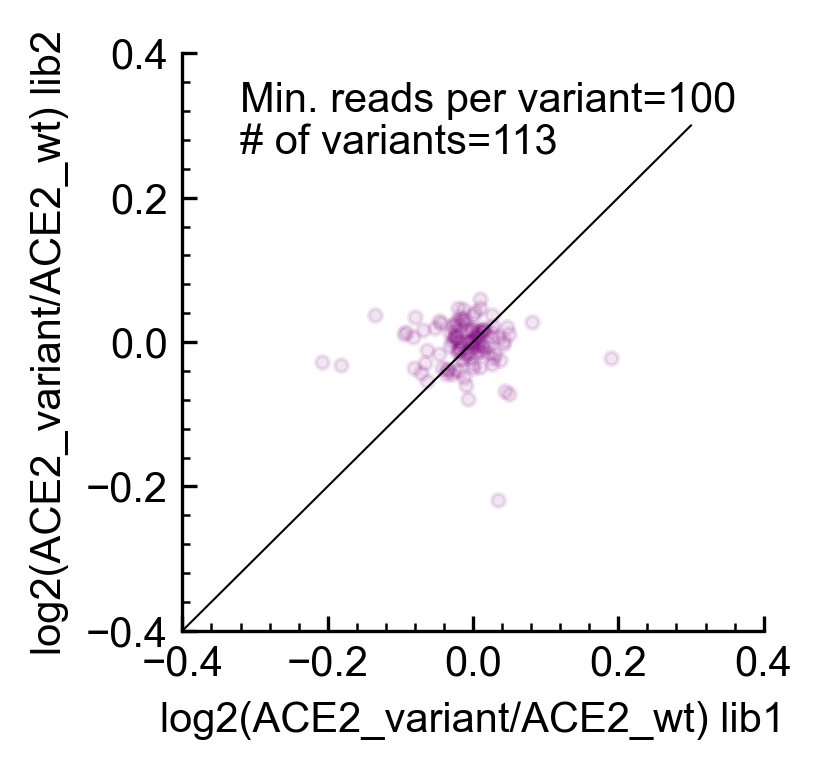

In [14]:
fig = plt.figure(figsize=(2.5,2.5))
fig.set_dpi(300)
ax = fig.add_subplot(111)
reads_threshold = 100
xvar = 'gaussian_center_log2_over_wt_x'
yvar = 'gaussian_center_log2_over_wt_y'
signal = 'ACE2'
xlabel = f'log2({signal}_variant/{signal}_wt) lib1'
ylabel = f'log2({signal}_variant/{signal}_wt) lib2'
df = mergeACE2
df = df[df.total_variant_reads_x>=reads_threshold]
N=len(df)
scatterkwargs = {
    'y': df[yvar],
    'x': df[xvar],
    'color': 'purple',
    'alpha': 0.1,
    's': 10
}

xlim = (-0.4, 0.4)
ylim = xlim
ax.set_ylim(xlim)
ax.set_xlim(xlim)

x_line = np.arange(np.min(xlim), np.max(xlim), 0.1)
y_line = fitting.line(x_line, 1, 0)

linekwargs = {
    'color': 'black',
    'linewidth': 0.5,
    'alpha': 1
}
ax.plot(x_line, y_line, **linekwargs)
ax.scatter(**scatterkwargs)
axrange = np.max(xlim) - np.min(xlim)
xy = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.8)
xyn = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.65)
ax.annotate(f'Min. reads per variant={reads_threshold}', xy=xy)
ax.annotate(f'# of variants={N}', xy=xyn)

ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
plotting.remove_spines(ax)
plotting.format_ticks(ax)

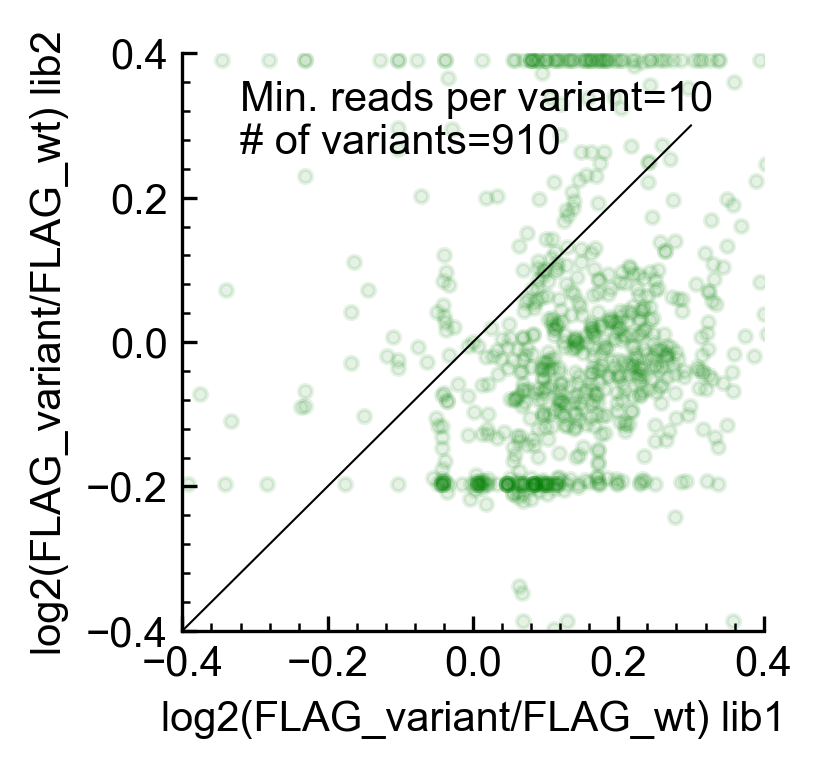

In [81]:
fig = plt.figure(figsize=(2.5,2.5))
fig.set_dpi(300)
ax = fig.add_subplot(111)
reads_threshold = 10
xvar = 'gaussian_center_log2_over_wt_x'
yvar = 'gaussian_center_log2_over_wt_y'
signal = 'FLAG'
xlabel = f'log2({signal}_variant/{signal}_wt) lib1'
ylabel = f'log2({signal}_variant/{signal}_wt) lib2'
df = mergeFLAG
df = df[df.total_variant_reads_x>=reads_threshold]
N=len(df)
scatterkwargs = {
    'y': df[yvar],
    'x': df[xvar],
    'color': 'green',
    'alpha': 0.1,
    's': 10
}

xlim = (-0.4, 0.4)
ylim = xlim
ax.set_ylim(xlim)
ax.set_xlim(xlim)

x_line = np.arange(np.min(xlim), np.max(xlim), 0.1)
y_line = fitting.line(x_line, 1, 0)

linekwargs = {
    'color': 'black',
    'linewidth': 0.5,
    'alpha': 1
}
ax.plot(x_line, y_line, **linekwargs)
ax.scatter(**scatterkwargs)
axrange = np.max(xlim) - np.min(xlim)
xy = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.8)
xyn = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.65)
ax.annotate(f'Min. reads per variant={reads_threshold}', xy=xy)
ax.annotate(f'# of variants={N}', xy=xyn)

ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
plotting.remove_spines(ax)
plotting.format_ticks(ax)

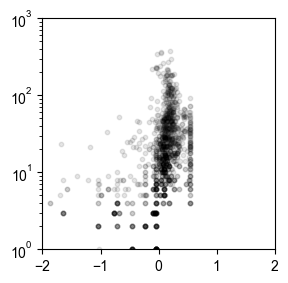

In [11]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
fitsdf = flaglib1df.copy()
fitsdf = fitsdf[fitsdf.total_variant_reads>=0]
scatterkwargs = {
    'y': fitsdf.total_variant_reads,
    'x': fitsdf.gaussian_center_log2_over_wt,
    'color': 'black',
    'alpha': 0.1,
    's': 10
}

ax.scatter(**scatterkwargs)

ax.set_yscale('log')
ax.set_xlim(-2, 2)
ax.set_ylim(1, 1000)
ax.set_yticks([1, 10, 100, 1000])

In [192]:
ace2lib1norm = flag_normalize(ace2lib1df, flaglib1df)
ace2lib2norm = flag_normalize(ace2lib2df, flaglib2df)

mergeACE2 = ace2lib1norm.merge(ace2lib2norm, on='variant_name', how='left')

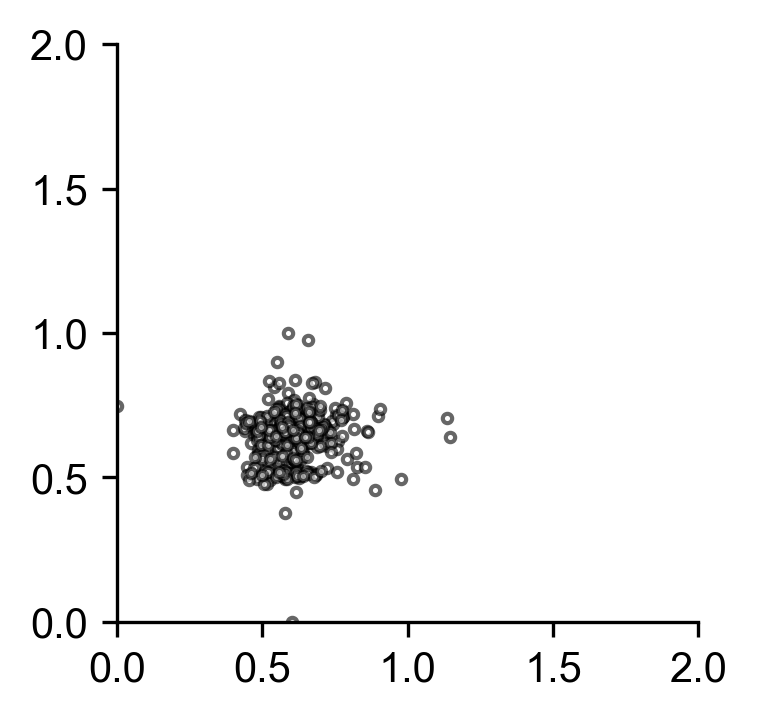

In [198]:
fig = plt.figure(figsize=(2.5, 2.5))
ax = fig.add_subplot(111)
fig.set_dpi(300)

df = mergeACE2.copy()

kwargs = {
    'facecolor': 'white',
    'edgecolor': 'black',
    's': 5,
    'alpha': 0.6
}


x = df.ace2_center_over_flag_center_x
y = df.ace2_center_over_flag_center_y


ax.scatter(x, y, **kwargs)
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)

# ax.set_yscale('log')
# ax.set_xscale('log')

plotting.remove_spines(ax)

Text(0, 0.5, 'Fraction of Reads')

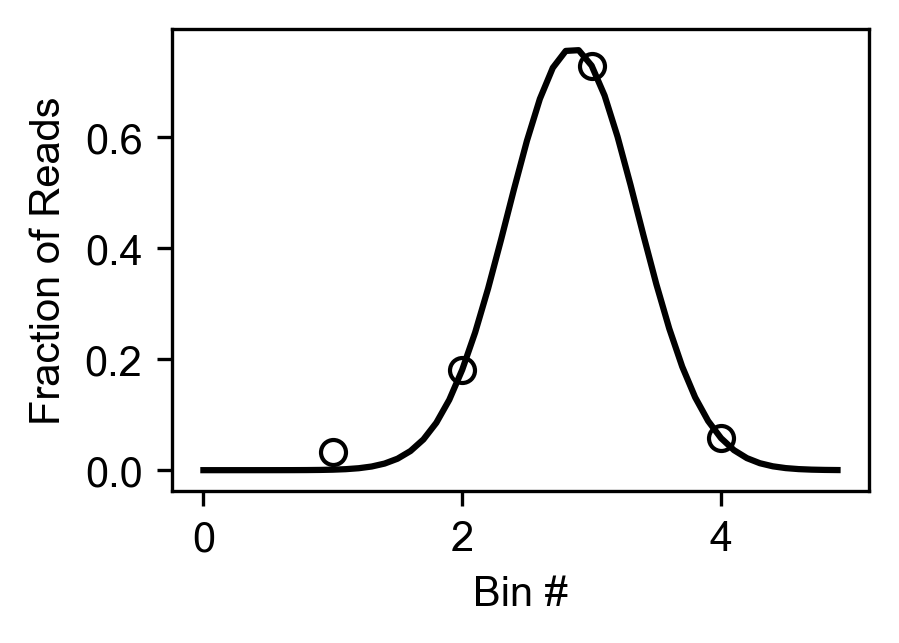

In [155]:
wtdf = alldf[alldf.is_wt==True]
wtdf = wtdf[wtdf.sample_library=='ACE2-Lib1']
wtdf = wtdf[wtdf.bin_number!=0]
wtcountdf = wtdf.groupby(['variant_name', 'bin_number']).count().reset_index()

wtfitsdf = ace2lib1df[ace2lib1df.is_wt==True]
params = (
    wtfitsdf.loc[:, 'gaussian_a'].values[0],
    wtfitsdf.loc[:, 'gaussian_center'].values[0],
    wtfitsdf.loc[:, 'gaussian_stdev'].values[0]
)

fig = plt.figure(figsize=(3, 2))
fig.set_dpi(300)
ax = fig.add_subplot(111)

xscatter = wtcountdf.bin_number
yscatter = wtcountdf.seq_id
yscatter_norm = yscatter/np.sum(yscatter)

xsmooth = np.arange(0, np.max(xscatter)+1, 0.1)
ypred = fitting.gaussian(xsmooth, *params)

ax.scatter(xscatter, yscatter_norm, edgecolor='black', facecolor='white')
ax.plot(xsmooth, ypred, color='black')

ax.set_xlabel('Bin #')
ax.set_ylabel('Fraction of Reads')

Text(0, 0.5, 'Number of variants')

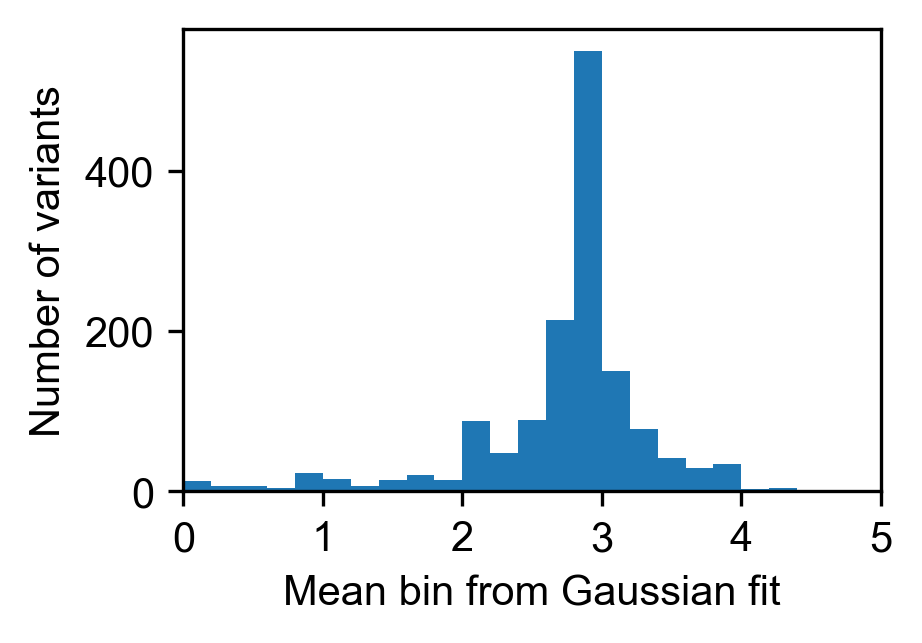

In [63]:
fig = plt.figure(figsize=(3, 2))
fig.set_dpi(300)
ax = fig.add_subplot(111)

ax.hist(ace2lib1df .gaussian_center, bins=30)
ax.set_xlim(0, 5)

ax.set_xlabel('Mean bin from Gaussian fit')
ax.set_ylabel('Number of variants')

Text(0, 0.5, 'Number of reads')

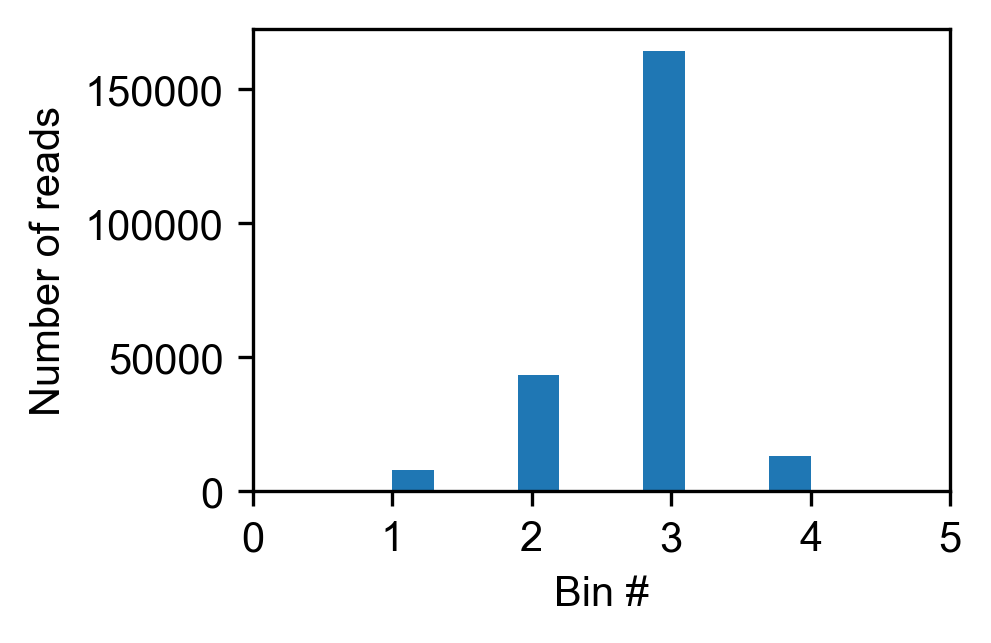

In [64]:
fig = plt.figure(figsize=(3, 2))
fig.set_dpi(300)
ax = fig.add_subplot(111)

ax.hist(ace2lib1_df.bin_number)
ax.set_xlim(0, 5)

ax.set_xlabel('Bin #')
ax.set_ylabel('Number of reads')

## Compare effects to bloom lab data

In [523]:
datadir = os.path.join(constants.source_path, 'data/bloom_lab')
filename = '1-s2.0-S0092867420310035-mmc2.csv'
filepath = os.path.join(datadir, filename)
bloomdf = pd.read_csv(filepath)

bloomdf.loc[:, 'variant_name'] = bloomdf.mutation_RBD

(array([ 3.,  1.,  9.,  8., 21., 22., 17., 19.,  8.,  3.]),
 array([-1.04116558, -0.97963602, -0.91810646, -0.8565769 , -0.79504734,
        -0.73351778, -0.67198821, -0.61045865, -0.54892909, -0.48739953,
        -0.42586997]),
 <a list of 10 Patch objects>)

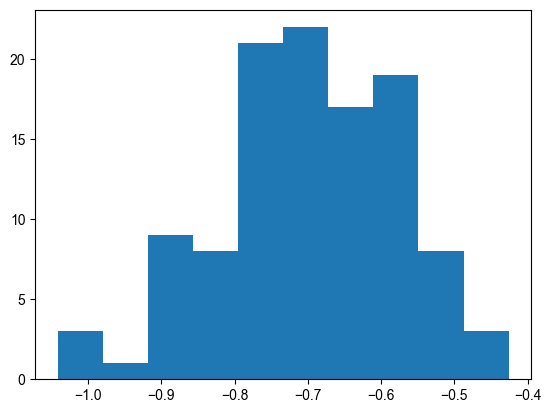

In [524]:
plt.hist(fits_df.log2_ratio_to_wt)

In [525]:

suffixes = [
    '_spikedisplay',
    '_bloom'
]

ACE2_bloom_merge = fits_df.merge(bloomdf,
                                   on='variant_name',
                                   how='left',
                                   suffixes=suffixes)

In [526]:
len(ACE2_bloom_merge.variant_name)

111

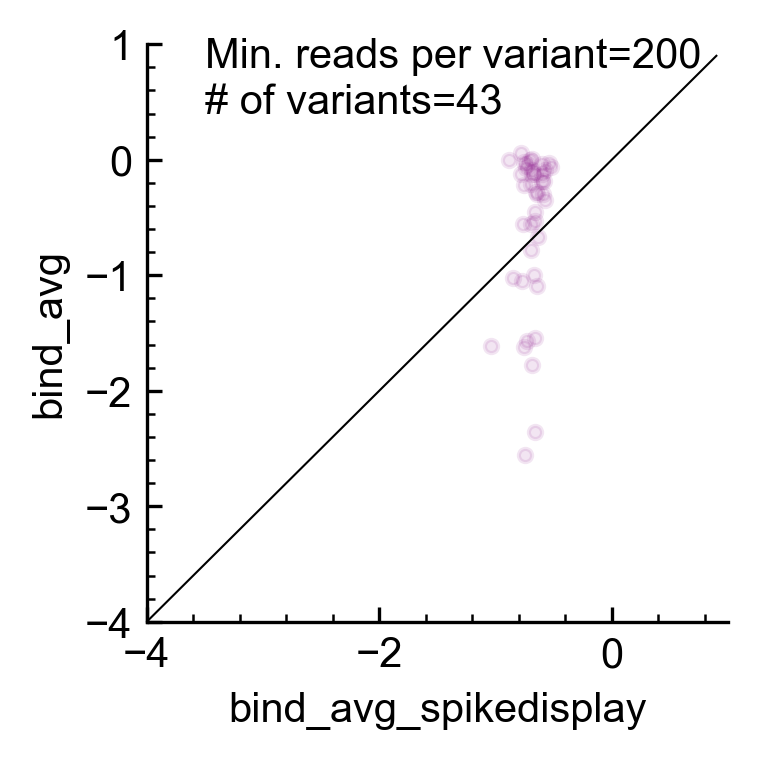

In [555]:
fig = plt.figure(figsize=(2.5,2.5))
fig.set_dpi(300)
ax = fig.add_subplot(111)
reads_threshold = 200
df = ACE2_bloom_merge
df = df[df.total_variant_reads>=reads_threshold]
xvar = 'log2_ratio_to_wt'
yvar = 'bind_avg'
signal = 'ACE2'
xlabel = xvar
xlabel='bind_avg_spikedisplay'
ylabel = yvar
N=len(df)
scatterkwargs = {
    'y': df[yvar],
    'x': df[xvar],
    'color': 'purple',
    'alpha': 0.1,
    's': 10
}

xlim = (-4, 1)
ylim = (-4, 1)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_line = np.arange(np.min(xlim), np.max(xlim), 0.1)
y_line = fitting.line(x_line, 1, 0)

linekwargs = {
    'color': 'black',
    'linewidth': 0.5,
    'alpha': 1
}
ax.plot(x_line, y_line, **linekwargs)
ax.scatter(**scatterkwargs)
axrange = np.max(xlim) - np.min(xlim)
xy = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.8)
xyn = (np.min(xlim) + 0.1*axrange, np.max(ylim)*0.4)
ax.annotate(f'Min. reads per variant={reads_threshold}', xy=xy)
ax.annotate(f'# of variants={N}', xy=xyn)
ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)
plotting.remove_spines(ax)
plotting.format_ticks(ax)

In [26]:
df.sort_values(by='bind_avg_bloom', ascending=True).loc[:, ]

is_wt_x mutant_aa_x wt_aa_at_mismatch_x  \
698     False           L                   R   
1448    False           Y                   S   
92      False           C                   G   
95      False           C                   G   
865     False           P                   A   

      mismatch_index_in_full_length_wt_seq_x  \
698                                      123   
1448                                     107   
92                                        85   
95                                       116   
865                                      144   

                         source_file_x sample_name_x library_name_x  \
698   ACE2-Lib1_S1_L001_001_bam.csv.gz          ACE2           Lib1   
1448  ACE2-Lib1_S1_L001_001_bam.csv.gz          ACE2           Lib1   
92    ACE2-Lib1_S1_L001_001_bam.csv.gz          ACE2           Lib1   
95    ACE2-Lib1_S1_L001_001_bam.csv.gz          ACE2           Lib1   
865   ACE2-Lib1_S1_L001_001_bam.csv.gz          ACE2           Lib1   

     variant_name sample_library_x  bin_number_x  ...  wildtype  mutant  \
698         R124L        ACE2-Lib1           2.5  ...         R       L   
1448        S108Y        ACE2-Lib1           2.5  ...         S       Y   
92           G86C        ACE2-Lib1           2.5  ...         G       C   
95          G117C        ACE2-Lib1           2.5  ...         G       C   
865         A145P        ACE2-Lib1           2.5  ...         A       P   

      mutation  mutation_RBD  bind_lib1  bind_lib2  bind_avg_bloom  expr_lib1  \
698      R454L         R124L      -4.67      -4.78           -4.73      -2.11   
1448     S438Y         S108Y      -2.49      -2.62           -2.56      -2.22   
92       G416C          G86C      -2.39      -2.33           -2.36      -2.17   
95       G447C         G117C      -1.76      -1.79           -1.78      -0.43   
865      A475P         A145P      -1.52      -1.72           -1.62      -1.44   

      expr_lib2  expr_avg  
698       -2.19     -2.15  
1448      -1.47     -1.85  
92        -2.15     -2.16  
95        -0.44     -0.43  
865       -1.34     -1.39  

[5 rows x 62 columns]

(array([ 295.,   72.,   67.,   57.,  116.,  140.,  204.,  387.,  786.,
        1879.]),
 array([-4.84 , -4.326, -3.812, -3.298, -2.784, -2.27 , -1.756, -1.242,
        -0.728, -0.214,  0.3  ]),
 <a list of 10 Patch objects>)

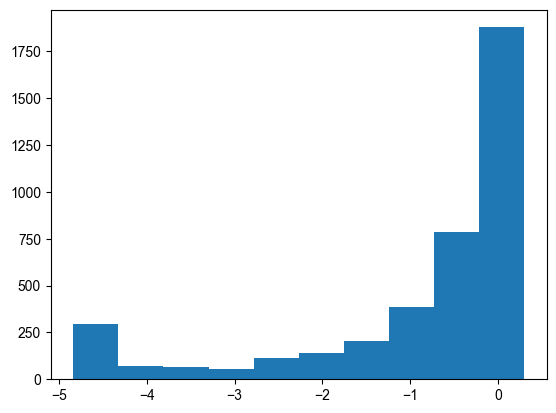

In [153]:
plt.hist(bloomdf.bind_avg)

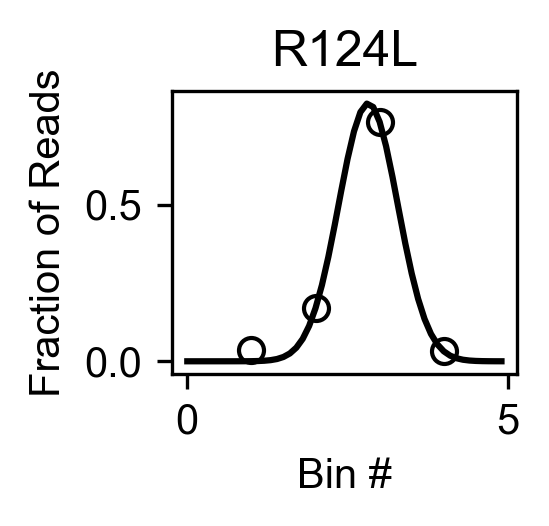

In [27]:
sample_library = 'ACE2-Lib1'
df = mergeACE2
reads_threshold = 50
df = df[df.total_variant_reads_x>=reads_threshold]
variants = list(df.variant_name.unique())

ncols = 6
nrows = int(np.round(len(variants)/ncols)+1)

fig = plt.figure(figsize=(8.5, 1.5*(nrows)))
fig.set_dpi(300)

i=1
for variant in variants:
    if variant == 'R124L':
        ax = fig.add_subplot(nrows, ncols, i)
        subdf = df[df.variant_name==variant]
        suballdf = alldf[alldf.variant_name==variant]
        suballdf = suballdf[suballdf.sample_library==sample_library]
        suballdf = suballdf[suballdf.bin_number!=0]
        subcountdf = suballdf.groupby(['variant_name', 'bin_number']).count().reset_index()
        params = (
            subdf.loc[:, 'gaussian_a_x'].values[0],
            subdf.loc[:, 'gaussian_center_x'].values[0],
            subdf.loc[:, 'gaussian_stdev_x'].values[0]
        )

        xscatter = subcountdf.bin_number
        yscatter = subcountdf.seq_id
        yscatter_norm = yscatter/np.sum(yscatter)

        xsmooth = np.arange(0, np.max(xscatter)+1, 0.1)
        ypred = fitting.gaussian(xsmooth, *params)

        ax.scatter(xscatter, yscatter_norm, edgecolor='black', facecolor='white')
        ax.plot(xsmooth, ypred, color='black')

        ax.set_xlabel('Bin #')
        ax.set_ylabel('Fraction of Reads')
        ax.set_title(variant)
        i+=1
    
plt.tight_layout()